In [1]:
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
np.set_printoptions(threshold=np.inf)
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import math
from math import exp, pi,sin,cos

np.random.seed(1)
tf.set_random_seed(1)
tf.compat.v1.disable_eager_execution()
###########设置定义域范围
a = 0
b = 1
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, layers_UV,x_range, f, num_train_tps):

        # Initialize NNs
        self.layers_UV = layers_UV
        self.weights_UV, self.biases_UV, self.adaps_UV = self.initialize_NN(layers_UV)
        # Parameters
        self.x_range =x_range
        self.lb = np.array([ x_range[0]])
        self.ub = np.array([ x_range[1]])
        # Output file
        self.f = f
        # Coordinates of datapoints             #####################数据点坐标
        self.xx_tf = tf.placeholder(tf.float32, shape=[None, 1])
        # Test Points                           ######################测试点
        self.x_test_tf = tf.placeholder(tf.float32, shape=[None, 1])

        # Generate Training and Testing Points  ########################生成训练和测试点
        self.generateTrain(num_train_tps)

        # Physics
        self.f, self.e1,self.e2,self.e3,self.e4,  self.Uf, self.V1f,self.V2f,self.V3f,self.V4f,self.U_xf,self.V1_xf,self.V2_xf,self.V3_xf,self.V4_xf= self.pinn(self.xf)
        _,_,_,_,_,self.Ui, self.V1i,self.V2i,self.V3i,self.V4i,_,_,_,_,_= self.pinn(self.xi)
        self.f_test,  self.e1_test, self.e2_test,self.e3_test,self.e4_test,self.U_test, self.V1_test,self.V2_test,self.V3_test,self.V4_test,self.U_x_test,self.V1_x_test,self.V2_x_test,self.V3_x_test,self.V4_x_test= self.pinn(self.x_test_tf)
        # 均方误差
        self.loss_f = tf.reduce_mean((self.U_xf - (self.xf + 2) * self.V1f - self.xf * (
                    self.xf + 2) * self.V2f - 0.5 * self.xf ** 2 * (self.xf + 2) * self.V3f - self.xf ** 3 * (
                                                  self.xf + 2) * self.V4f / 6 - 2 * tf.exp(2 * self.xf) - 1.0 + tf.exp(
                    self.xf ** 2 + 2 * self.xf)) ** 2)
        self.loss_e1 = tf.reduce_mean((self.V1_xf -self.Uf) ** 2)
        self.loss_e2 = tf.reduce_mean((self.V2_xf - self.xf * self.Uf) ** 2)
        self.loss_e3 = tf.reduce_mean((self.V3_xf - self.xf ** 2 * self.Uf) ** 2)
        self.loss_e4 = tf.reduce_mean((self.V4_xf - self.xf ** 3 * self.Uf) ** 2)
        self.loss_i = tf.reduce_mean((self.Ui - 1) ** 2) + tf.reduce_mean((self.V1i - 0) ** 2) \
                      + tf.reduce_mean((self.V2i -0) ** 2) + tf.reduce_mean((self.V3i - 0) ** 2) + tf.reduce_mean(
                      (self.V4i - 0) ** 2)
        self.loss = self.loss_f * 1 + self.loss_e1 * 1 + self.loss_e2 * 1 + self.loss_e3 * 1 + self.loss_e4 * 1 + self.loss_i * 1
        # Optimizer
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)

#####################初始化神经网络参数
    def initialize_NN(self, layers):
        weights = []
        biases = []
        adaps = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            a = tf.Variable(1.0, dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            adaps.append(a)
        return weights, biases, adaps

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def net_UV(self, X):
        weights = self.weights_UV
        biases = self.biases_UV
        adaps = self.adaps_UV
        num_layers = len(weights) + 1
        h = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            a = adaps[l]
            h = tf.nn.tanh(tf.multiply(a, tf.add(tf.matmul(h, W), b)))
        W = weights[-1]
        b = biases[-1]
        UV= tf.add(tf.matmul(h, W), b)
        return UV

    #
    def pinn(self,x):
        X=x
        # x=self.x_range[1] * tf.ones(x.shape)
        UV= self.net_UV(X)
        U = UV[:, 0:1]
        V1 = UV[:, 1:2]
        V2= UV[:, 2:3]
        V3 = UV[:, 3:4]
        V4 = UV[:, 4:5]

        U_x = tf.gradients(U, x)  # du/dx
        V1_x = tf.gradients(V1, x)  # dv/dx
        V2_x = tf.gradients(V2, x)  # dv/dx
        V3_x = tf.gradients(V3, x)  # dv/dx
        V4_x = tf.gradients(V4, x)
        f = U_x-(x+2)*V1-x*(x+2)*V2-0.5*x**2*(x+2)*V3-2*tf.exp(2*x)-1.0+tf.exp(x**2+2*x)
        e1 =V1_x-U
        e2 = V2_x-x*U
        e3 =V3_x -x**2* U
        e4 = V4_x - x ** 3 * U

        return f,e1,e2,e3,e4,U,V1,V2,V3,V4, U_x ,V1_x,V2_x,V3_x,V4_x


    def generateTrain(self, num_train_tps):
        xf = tf.linspace(np.float32(self.x_range[0]), np.float32(self.x_range[1]),200)
        self.xf = tf.reshape(xf, [-1, 1])
        xi = self.x_range[0] * tf.ones(xf.shape)
        self.xi = tf.reshape(xi, [-1, 1])
        xe = self.x_range[1] * tf.ones(xf.shape)
        self.xe = tf.reshape(xe, [-1, 1])
        return

    def train(self, xx,  it, num_train_tps):
        xx = np.linspace(self.x_range[0], self.x_range[1],num_train_tps)
        xx = np.reshape(xx, [-1, 1])
        tf_dict = {self.xx_tf: xx}
        self.sess.run(self.train_op_Adam, tf_dict)

        loss_value, loss_value_f,loss_value_e1,loss_value_e2,loss_value_e3,loss_value_e4,loss_value_i= self.sess.run(
            [self.loss, self.loss_f,self.loss_e1,self.loss_e2,self.loss_e3,self.loss_e4,self.loss_i
             ], tf_dict)
        loss_value_array = [loss_value_f*1,loss_value_e1*1,loss_value_e2*1,loss_value_e3*1,loss_value_e4*1,loss_value_i*1]
        np.set_printoptions(precision=6)
        content = 'It: %d, Loss: %.3e' % (it, loss_value) 
        print(content, flush=True)
        return loss_value, loss_value_array


    def test(self, num_test_tps):
        x = np.linspace(self.x_range[0], self.x_range[1], num_test_tps)
        x_test = np.reshape(x, [-1, 1])
        tf_dict = {self.x_test_tf: x_test}
        U_test = self.sess.run(self.U_test, tf_dict)
        V1_test = self.sess.run(self.V1_test, tf_dict)
        V2_test = self.sess.run(self.V2_test, tf_dict)
        V3_test = self.sess.run(self.V3_test, tf_dict)
        V4_test = self.sess.run(self.V4_test, tf_dict)
        U_test_x = tf.gradients(U_test, x_test)  # du/dx
        V1_test_x = tf.gradients(V1_test, x_test)  # du/dx
        V2_test_x = tf.gradients(V2_test, x_test)  # du/dx
        V3_test_x = tf.gradients(V3_test, x_test)  # du/dx
        V4_test_x = tf.gradients(V4_test, x_test)
        f_test = self.sess.run(self.f_test, tf_dict)
        e1_test = self.sess.run(self.e1_test, tf_dict)
        e2_test = self.sess.run(self.e2_test, tf_dict)
        e3_test = self.sess.run(self.e3_test, tf_dict)
        e4_test = self.sess.run(self.e4_test, tf_dict)
        return x_test, U_test, V1_test, V2_test,V3_test,V4_test,f_test,e1_test,e2_test,e3_test,e4_test,U_test_x,V1_test_x,V2_test_x,V3_test_x,V4_test_x


It: 1, Loss: 7.080e+00
It: 2, Loss: 6.601e+00
It: 3, Loss: 6.190e+00
It: 4, Loss: 5.839e+00
It: 5, Loss: 5.544e+00
It: 6, Loss: 5.298e+00
It: 7, Loss: 5.094e+00
It: 8, Loss: 4.926e+00
It: 9, Loss: 4.789e+00
It: 10, Loss: 4.677e+00
It: 11, Loss: 4.584e+00
It: 12, Loss: 4.506e+00
It: 13, Loss: 4.440e+00
It: 14, Loss: 4.381e+00
It: 15, Loss: 4.328e+00
It: 16, Loss: 4.278e+00
It: 17, Loss: 4.229e+00
It: 18, Loss: 4.180e+00
It: 19, Loss: 4.131e+00
It: 20, Loss: 4.082e+00
It: 21, Loss: 4.031e+00
It: 22, Loss: 3.978e+00
It: 23, Loss: 3.924e+00
It: 24, Loss: 3.869e+00
It: 25, Loss: 3.812e+00
It: 26, Loss: 3.754e+00
It: 27, Loss: 3.696e+00
It: 28, Loss: 3.636e+00
It: 29, Loss: 3.576e+00
It: 30, Loss: 3.516e+00
It: 31, Loss: 3.456e+00
It: 32, Loss: 3.397e+00
It: 33, Loss: 3.337e+00
It: 34, Loss: 3.278e+00
It: 35, Loss: 3.220e+00
It: 36, Loss: 3.163e+00
It: 37, Loss: 3.107e+00
It: 38, Loss: 3.053e+00
It: 39, Loss: 3.000e+00
It: 40, Loss: 2.950e+00
It: 41, Loss: 2.903e+00
It: 42, Loss: 2.857e+00
I

It: 334, Loss: 1.949e-01
It: 335, Loss: 1.930e-01
It: 336, Loss: 1.910e-01
It: 337, Loss: 1.891e-01
It: 338, Loss: 1.872e-01
It: 339, Loss: 1.853e-01
It: 340, Loss: 1.834e-01
It: 341, Loss: 1.815e-01
It: 342, Loss: 1.796e-01
It: 343, Loss: 1.778e-01
It: 344, Loss: 1.759e-01
It: 345, Loss: 1.741e-01
It: 346, Loss: 1.723e-01
It: 347, Loss: 1.705e-01
It: 348, Loss: 1.687e-01
It: 349, Loss: 1.670e-01
It: 350, Loss: 1.652e-01
It: 351, Loss: 1.635e-01
It: 352, Loss: 1.618e-01
It: 353, Loss: 1.601e-01
It: 354, Loss: 1.584e-01
It: 355, Loss: 1.567e-01
It: 356, Loss: 1.550e-01
It: 357, Loss: 1.534e-01
It: 358, Loss: 1.517e-01
It: 359, Loss: 1.501e-01
It: 360, Loss: 1.485e-01
It: 361, Loss: 1.469e-01
It: 362, Loss: 1.453e-01
It: 363, Loss: 1.437e-01
It: 364, Loss: 1.421e-01
It: 365, Loss: 1.406e-01
It: 366, Loss: 1.390e-01
It: 367, Loss: 1.375e-01
It: 368, Loss: 1.360e-01
It: 369, Loss: 1.345e-01
It: 370, Loss: 1.330e-01
It: 371, Loss: 1.315e-01
It: 372, Loss: 1.301e-01
It: 373, Loss: 1.286e-01


It: 662, Loss: 4.775e-03
It: 663, Loss: 4.737e-03
It: 664, Loss: 4.699e-03
It: 665, Loss: 4.662e-03
It: 666, Loss: 4.625e-03
It: 667, Loss: 4.589e-03
It: 668, Loss: 4.553e-03
It: 669, Loss: 4.518e-03
It: 670, Loss: 4.482e-03
It: 671, Loss: 4.448e-03
It: 672, Loss: 4.413e-03
It: 673, Loss: 4.379e-03
It: 674, Loss: 4.345e-03
It: 675, Loss: 4.312e-03
It: 676, Loss: 4.279e-03
It: 677, Loss: 4.246e-03
It: 678, Loss: 4.214e-03
It: 679, Loss: 4.182e-03
It: 680, Loss: 4.151e-03
It: 681, Loss: 4.119e-03
It: 682, Loss: 4.088e-03
It: 683, Loss: 4.058e-03
It: 684, Loss: 4.027e-03
It: 685, Loss: 3.997e-03
It: 686, Loss: 3.968e-03
It: 687, Loss: 3.938e-03
It: 688, Loss: 3.909e-03
It: 689, Loss: 3.880e-03
It: 690, Loss: 3.852e-03
It: 691, Loss: 3.823e-03
It: 692, Loss: 3.795e-03
It: 693, Loss: 3.768e-03
It: 694, Loss: 3.741e-03
It: 695, Loss: 3.713e-03
It: 696, Loss: 3.687e-03
It: 697, Loss: 3.660e-03
It: 698, Loss: 3.634e-03
It: 699, Loss: 3.609e-03
It: 700, Loss: 3.584e-03
It: 701, Loss: 3.559e-03


It: 990, Loss: 9.087e-04
It: 991, Loss: 9.056e-04
It: 992, Loss: 9.025e-04
It: 993, Loss: 8.995e-04
It: 994, Loss: 8.965e-04
It: 995, Loss: 8.936e-04
It: 996, Loss: 8.907e-04
It: 997, Loss: 8.878e-04
It: 998, Loss: 8.848e-04
It: 999, Loss: 8.819e-04
It: 1000, Loss: 8.790e-04
It: 1001, Loss: 8.761e-04
It: 1002, Loss: 8.732e-04
It: 1003, Loss: 8.704e-04
It: 1004, Loss: 8.675e-04
It: 1005, Loss: 8.647e-04
It: 1006, Loss: 8.619e-04
It: 1007, Loss: 8.591e-04
It: 1008, Loss: 8.563e-04
It: 1009, Loss: 8.535e-04
It: 1010, Loss: 8.507e-04
It: 1011, Loss: 8.480e-04
It: 1012, Loss: 8.452e-04
It: 1013, Loss: 8.425e-04
It: 1014, Loss: 8.398e-04
It: 1015, Loss: 8.371e-04
It: 1016, Loss: 8.344e-04
It: 1017, Loss: 8.317e-04
It: 1018, Loss: 8.291e-04
It: 1019, Loss: 8.264e-04
It: 1020, Loss: 8.238e-04
It: 1021, Loss: 8.212e-04
It: 1022, Loss: 8.185e-04
It: 1023, Loss: 8.159e-04
It: 1024, Loss: 8.134e-04
It: 1025, Loss: 8.108e-04
It: 1026, Loss: 8.082e-04
It: 1027, Loss: 8.056e-04
It: 1028, Loss: 8.031e

It: 1305, Loss: 4.001e-03
It: 1306, Loss: 5.435e-03
It: 1307, Loss: 3.858e-03
It: 1308, Loss: 1.163e-03
It: 1309, Loss: 5.001e-04
It: 1310, Loss: 2.035e-03
It: 1311, Loss: 3.222e-03
It: 1312, Loss: 2.436e-03
It: 1313, Loss: 8.194e-04
It: 1314, Loss: 4.846e-04
It: 1315, Loss: 1.475e-03
It: 1316, Loss: 2.076e-03
It: 1317, Loss: 1.434e-03
It: 1318, Loss: 5.210e-04
It: 1319, Loss: 5.358e-04
It: 1320, Loss: 1.189e-03
It: 1321, Loss: 1.377e-03
It: 1322, Loss: 8.553e-04
It: 1323, Loss: 4.035e-04
It: 1324, Loss: 5.727e-04
It: 1325, Loss: 9.569e-04
It: 1326, Loss: 9.327e-04
It: 1327, Loss: 5.668e-04
It: 1328, Loss: 3.854e-04
It: 1329, Loss: 5.671e-04
It: 1330, Loss: 7.609e-04
It: 1331, Loss: 6.676e-04
It: 1332, Loss: 4.428e-04
It: 1333, Loss: 3.929e-04
It: 1334, Loss: 5.307e-04
It: 1335, Loss: 6.143e-04
It: 1336, Loss: 5.224e-04
It: 1337, Loss: 3.961e-04
It: 1338, Loss: 3.963e-04
It: 1339, Loss: 4.854e-04
It: 1340, Loss: 5.163e-04
It: 1341, Loss: 4.479e-04
It: 1342, Loss: 3.794e-04
It: 1343, Lo

It: 1621, Loss: 2.402e-04
It: 1622, Loss: 2.393e-04
It: 1623, Loss: 2.468e-04
It: 1624, Loss: 2.477e-04
It: 1625, Loss: 2.404e-04
It: 1626, Loss: 2.364e-04
It: 1627, Loss: 2.401e-04
It: 1628, Loss: 2.431e-04
It: 1629, Loss: 2.398e-04
It: 1630, Loss: 2.354e-04
It: 1631, Loss: 2.358e-04
It: 1632, Loss: 2.385e-04
It: 1633, Loss: 2.381e-04
It: 1634, Loss: 2.349e-04
It: 1635, Loss: 2.335e-04
It: 1636, Loss: 2.348e-04
It: 1637, Loss: 2.357e-04
It: 1638, Loss: 2.341e-04
It: 1639, Loss: 2.322e-04
It: 1640, Loss: 2.322e-04
It: 1641, Loss: 2.331e-04
It: 1642, Loss: 2.328e-04
It: 1643, Loss: 2.314e-04
It: 1644, Loss: 2.305e-04
It: 1645, Loss: 2.307e-04
It: 1646, Loss: 2.310e-04
It: 1647, Loss: 2.304e-04
It: 1648, Loss: 2.294e-04
It: 1649, Loss: 2.290e-04
It: 1650, Loss: 2.291e-04
It: 1651, Loss: 2.290e-04
It: 1652, Loss: 2.283e-04
It: 1653, Loss: 2.277e-04
It: 1654, Loss: 2.274e-04
It: 1655, Loss: 2.274e-04
It: 1656, Loss: 2.271e-04
It: 1657, Loss: 2.266e-04
It: 1658, Loss: 2.261e-04
It: 1659, Lo

It: 1937, Loss: 1.984e-04
It: 1938, Loss: 1.693e-04
It: 1939, Loss: 1.681e-04
It: 1940, Loss: 1.880e-04
It: 1941, Loss: 1.954e-04
It: 1942, Loss: 1.800e-04
It: 1943, Loss: 1.647e-04
It: 1944, Loss: 1.677e-04
It: 1945, Loss: 1.797e-04
It: 1946, Loss: 1.814e-04
It: 1947, Loss: 1.709e-04
It: 1948, Loss: 1.629e-04
It: 1949, Loss: 1.660e-04
It: 1950, Loss: 1.729e-04
It: 1951, Loss: 1.729e-04
It: 1952, Loss: 1.663e-04
It: 1953, Loss: 1.619e-04
It: 1954, Loss: 1.640e-04
It: 1955, Loss: 1.680e-04
It: 1956, Loss: 1.677e-04
It: 1957, Loss: 1.636e-04
It: 1958, Loss: 1.610e-04
It: 1959, Loss: 1.621e-04
It: 1960, Loss: 1.644e-04
It: 1961, Loss: 1.643e-04
It: 1962, Loss: 1.619e-04
It: 1963, Loss: 1.601e-04
It: 1964, Loss: 1.606e-04
It: 1965, Loss: 1.619e-04
It: 1966, Loss: 1.620e-04
It: 1967, Loss: 1.606e-04
It: 1968, Loss: 1.594e-04
It: 1969, Loss: 1.593e-04
It: 1970, Loss: 1.600e-04
It: 1971, Loss: 1.602e-04
It: 1972, Loss: 1.595e-04
It: 1973, Loss: 1.586e-04
It: 1974, Loss: 1.583e-04
It: 1975, Lo

It: 2253, Loss: 1.263e-04
It: 2254, Loss: 1.247e-04
It: 2255, Loss: 1.243e-04
It: 2256, Loss: 1.251e-04
It: 2257, Loss: 1.259e-04
It: 2258, Loss: 1.256e-04
It: 2259, Loss: 1.245e-04
It: 2260, Loss: 1.237e-04
It: 2261, Loss: 1.237e-04
It: 2262, Loss: 1.242e-04
It: 2263, Loss: 1.244e-04
It: 2264, Loss: 1.241e-04
It: 2265, Loss: 1.234e-04
It: 2266, Loss: 1.230e-04
It: 2267, Loss: 1.230e-04
It: 2268, Loss: 1.232e-04
It: 2269, Loss: 1.233e-04
It: 2270, Loss: 1.230e-04
It: 2271, Loss: 1.226e-04
It: 2272, Loss: 1.224e-04
It: 2273, Loss: 1.223e-04
It: 2274, Loss: 1.224e-04
It: 2275, Loss: 1.224e-04
It: 2276, Loss: 1.222e-04
It: 2277, Loss: 1.219e-04
It: 2278, Loss: 1.217e-04
It: 2279, Loss: 1.216e-04
It: 2280, Loss: 1.216e-04
It: 2281, Loss: 1.216e-04
It: 2282, Loss: 1.215e-04
It: 2283, Loss: 1.213e-04
It: 2284, Loss: 1.211e-04
It: 2285, Loss: 1.210e-04
It: 2286, Loss: 1.209e-04
It: 2287, Loss: 1.209e-04
It: 2288, Loss: 1.208e-04
It: 2289, Loss: 1.206e-04
It: 2290, Loss: 1.205e-04
It: 2291, Lo

It: 2569, Loss: 1.001e-04
It: 2570, Loss: 1.001e-04
It: 2571, Loss: 9.998e-05
It: 2572, Loss: 9.987e-05
It: 2573, Loss: 9.977e-05
It: 2574, Loss: 9.970e-05
It: 2575, Loss: 9.965e-05
It: 2576, Loss: 9.958e-05
It: 2577, Loss: 9.949e-05
It: 2578, Loss: 9.940e-05
It: 2579, Loss: 9.932e-05
It: 2580, Loss: 9.925e-05
It: 2581, Loss: 9.919e-05
It: 2582, Loss: 9.911e-05
It: 2583, Loss: 9.903e-05
It: 2584, Loss: 9.895e-05
It: 2585, Loss: 9.887e-05
It: 2586, Loss: 9.880e-05
It: 2587, Loss: 9.873e-05
It: 2588, Loss: 9.866e-05
It: 2589, Loss: 9.858e-05
It: 2590, Loss: 9.850e-05
It: 2591, Loss: 9.843e-05
It: 2592, Loss: 9.836e-05
It: 2593, Loss: 9.829e-05
It: 2594, Loss: 9.821e-05
It: 2595, Loss: 9.813e-05
It: 2596, Loss: 9.806e-05
It: 2597, Loss: 9.799e-05
It: 2598, Loss: 9.792e-05
It: 2599, Loss: 9.784e-05
It: 2600, Loss: 9.777e-05
It: 2601, Loss: 9.770e-05
It: 2602, Loss: 9.762e-05
It: 2603, Loss: 9.755e-05
It: 2604, Loss: 9.748e-05
It: 2605, Loss: 9.741e-05
It: 2606, Loss: 9.733e-05
It: 2607, Lo

It: 2885, Loss: 8.284e-05
It: 2886, Loss: 8.279e-05
It: 2887, Loss: 8.268e-05
It: 2888, Loss: 8.256e-05
It: 2889, Loss: 8.247e-05
It: 2890, Loss: 8.243e-05
It: 2891, Loss: 8.242e-05
It: 2892, Loss: 8.238e-05
It: 2893, Loss: 8.231e-05
It: 2894, Loss: 8.222e-05
It: 2895, Loss: 8.214e-05
It: 2896, Loss: 8.208e-05
It: 2897, Loss: 8.204e-05
It: 2898, Loss: 8.200e-05
It: 2899, Loss: 8.195e-05
It: 2900, Loss: 8.188e-05
It: 2901, Loss: 8.181e-05
It: 2902, Loss: 8.174e-05
It: 2903, Loss: 8.169e-05
It: 2904, Loss: 8.164e-05
It: 2905, Loss: 8.159e-05
It: 2906, Loss: 8.154e-05
It: 2907, Loss: 8.148e-05
It: 2908, Loss: 8.141e-05
It: 2909, Loss: 8.135e-05
It: 2910, Loss: 8.130e-05
It: 2911, Loss: 8.124e-05
It: 2912, Loss: 8.119e-05
It: 2913, Loss: 8.114e-05
It: 2914, Loss: 8.108e-05
It: 2915, Loss: 8.102e-05
It: 2916, Loss: 8.097e-05
It: 2917, Loss: 8.091e-05
It: 2918, Loss: 8.086e-05
It: 2919, Loss: 8.081e-05
It: 2920, Loss: 8.075e-05
It: 2921, Loss: 8.070e-05
It: 2922, Loss: 8.064e-05
It: 2923, Lo

It: 3201, Loss: 6.977e-05
It: 3202, Loss: 6.973e-05
It: 3203, Loss: 6.968e-05
It: 3204, Loss: 6.963e-05
It: 3205, Loss: 6.959e-05
It: 3206, Loss: 6.955e-05
It: 3207, Loss: 6.950e-05
It: 3208, Loss: 6.946e-05
It: 3209, Loss: 6.942e-05
It: 3210, Loss: 6.937e-05
It: 3211, Loss: 6.933e-05
It: 3212, Loss: 6.929e-05
It: 3213, Loss: 6.924e-05
It: 3214, Loss: 6.920e-05
It: 3215, Loss: 6.915e-05
It: 3216, Loss: 6.911e-05
It: 3217, Loss: 6.907e-05
It: 3218, Loss: 6.902e-05
It: 3219, Loss: 6.898e-05
It: 3220, Loss: 6.894e-05
It: 3221, Loss: 6.890e-05
It: 3222, Loss: 6.885e-05
It: 3223, Loss: 6.881e-05
It: 3224, Loss: 6.876e-05
It: 3225, Loss: 6.872e-05
It: 3226, Loss: 6.868e-05
It: 3227, Loss: 6.863e-05
It: 3228, Loss: 6.859e-05
It: 3229, Loss: 6.855e-05
It: 3230, Loss: 6.851e-05
It: 3231, Loss: 6.846e-05
It: 3232, Loss: 6.842e-05
It: 3233, Loss: 6.838e-05
It: 3234, Loss: 6.834e-05
It: 3235, Loss: 6.829e-05
It: 3236, Loss: 6.825e-05
It: 3237, Loss: 6.821e-05
It: 3238, Loss: 6.816e-05
It: 3239, Lo

It: 3517, Loss: 6.001e-05
It: 3518, Loss: 5.997e-05
It: 3519, Loss: 5.993e-05
It: 3520, Loss: 5.990e-05
It: 3521, Loss: 5.986e-05
It: 3522, Loss: 5.983e-05
It: 3523, Loss: 5.979e-05
It: 3524, Loss: 5.976e-05
It: 3525, Loss: 5.972e-05
It: 3526, Loss: 5.969e-05
It: 3527, Loss: 5.965e-05
It: 3528, Loss: 5.962e-05
It: 3529, Loss: 5.958e-05
It: 3530, Loss: 5.955e-05
It: 3531, Loss: 5.951e-05
It: 3532, Loss: 5.948e-05
It: 3533, Loss: 5.944e-05
It: 3534, Loss: 5.941e-05
It: 3535, Loss: 5.937e-05
It: 3536, Loss: 5.934e-05
It: 3537, Loss: 5.930e-05
It: 3538, Loss: 5.927e-05
It: 3539, Loss: 5.923e-05
It: 3540, Loss: 5.920e-05
It: 3541, Loss: 5.916e-05
It: 3542, Loss: 5.913e-05
It: 3543, Loss: 5.910e-05
It: 3544, Loss: 5.906e-05
It: 3545, Loss: 5.902e-05
It: 3546, Loss: 5.899e-05
It: 3547, Loss: 5.896e-05
It: 3548, Loss: 5.892e-05
It: 3549, Loss: 5.889e-05
It: 3550, Loss: 5.885e-05
It: 3551, Loss: 5.882e-05
It: 3552, Loss: 5.878e-05
It: 3553, Loss: 5.875e-05
It: 3554, Loss: 5.872e-05
It: 3555, Lo

It: 3833, Loss: 5.259e-05
It: 3834, Loss: 5.256e-05
It: 3835, Loss: 5.253e-05
It: 3836, Loss: 5.250e-05
It: 3837, Loss: 5.247e-05
It: 3838, Loss: 5.244e-05
It: 3839, Loss: 5.241e-05
It: 3840, Loss: 5.238e-05
It: 3841, Loss: 5.235e-05
It: 3842, Loss: 5.232e-05
It: 3843, Loss: 5.229e-05
It: 3844, Loss: 5.226e-05
It: 3845, Loss: 5.224e-05
It: 3846, Loss: 5.221e-05
It: 3847, Loss: 5.218e-05
It: 3848, Loss: 5.215e-05
It: 3849, Loss: 5.212e-05
It: 3850, Loss: 5.209e-05
It: 3851, Loss: 5.206e-05
It: 3852, Loss: 5.203e-05
It: 3853, Loss: 5.201e-05
It: 3854, Loss: 5.198e-05
It: 3855, Loss: 5.195e-05
It: 3856, Loss: 5.192e-05
It: 3857, Loss: 5.189e-05
It: 3858, Loss: 5.186e-05
It: 3859, Loss: 5.184e-05
It: 3860, Loss: 5.181e-05
It: 3861, Loss: 5.178e-05
It: 3862, Loss: 5.176e-05
It: 3863, Loss: 5.174e-05
It: 3864, Loss: 5.172e-05
It: 3865, Loss: 5.171e-05
It: 3866, Loss: 5.170e-05
It: 3867, Loss: 5.170e-05
It: 3868, Loss: 5.172e-05
It: 3869, Loss: 5.176e-05
It: 3870, Loss: 5.185e-05
It: 3871, Lo

It: 4149, Loss: 2.960e-04
It: 4150, Loss: 4.574e-04
It: 4151, Loss: 7.226e-04
It: 4152, Loss: 1.163e-03
It: 4153, Loss: 1.871e-03
It: 4154, Loss: 3.009e-03
It: 4155, Loss: 4.692e-03
It: 4156, Loss: 7.075e-03
It: 4157, Loss: 9.748e-03
It: 4158, Loss: 1.206e-02
It: 4159, Loss: 1.209e-02
It: 4160, Loss: 9.265e-03
It: 4161, Loss: 4.340e-03
It: 4162, Loss: 6.656e-04
It: 4163, Loss: 3.772e-04
It: 4164, Loss: 2.739e-03
It: 4165, Loss: 5.031e-03
It: 4166, Loss: 4.877e-03
It: 4167, Loss: 2.577e-03
It: 4168, Loss: 3.947e-04
It: 4169, Loss: 2.846e-04
It: 4170, Loss: 1.764e-03
It: 4171, Loss: 2.809e-03
It: 4172, Loss: 2.248e-03
It: 4173, Loss: 7.822e-04
It: 4174, Loss: 5.273e-05
It: 4175, Loss: 5.894e-04
It: 4176, Loss: 1.439e-03
It: 4177, Loss: 1.503e-03
It: 4178, Loss: 7.524e-04
It: 4179, Loss: 1.112e-04
It: 4180, Loss: 2.039e-04
It: 4181, Loss: 7.151e-04
It: 4182, Loss: 9.279e-04
It: 4183, Loss: 5.973e-04
It: 4184, Loss: 1.566e-04
It: 4185, Loss: 8.170e-05
It: 4186, Loss: 3.486e-04
It: 4187, Lo

It: 4465, Loss: 1.857e-04
It: 4466, Loss: 8.881e-05
It: 4467, Loss: 4.869e-05
It: 4468, Loss: 9.641e-05
It: 4469, Loss: 1.440e-04
It: 4470, Loss: 1.231e-04
It: 4471, Loss: 6.739e-05
It: 4472, Loss: 4.911e-05
It: 4473, Loss: 7.813e-05
It: 4474, Loss: 1.030e-04
It: 4475, Loss: 8.899e-05
It: 4476, Loss: 5.778e-05
It: 4477, Loss: 4.830e-05
It: 4478, Loss: 6.442e-05
It: 4479, Loss: 7.785e-05
It: 4480, Loss: 7.017e-05
It: 4481, Loss: 5.297e-05
It: 4482, Loss: 4.712e-05
It: 4483, Loss: 5.527e-05
It: 4484, Loss: 6.283e-05
It: 4485, Loss: 5.943e-05
It: 4486, Loss: 5.018e-05
It: 4487, Loss: 4.609e-05
It: 4488, Loss: 4.965e-05
It: 4489, Loss: 5.395e-05
It: 4490, Loss: 5.296e-05
It: 4491, Loss: 4.825e-05
It: 4492, Loss: 4.535e-05
It: 4493, Loss: 4.645e-05
It: 4494, Loss: 4.875e-05
It: 4495, Loss: 4.886e-05
It: 4496, Loss: 4.674e-05
It: 4497, Loss: 4.484e-05
It: 4498, Loss: 4.479e-05
It: 4499, Loss: 4.581e-05
It: 4500, Loss: 4.622e-05
It: 4501, Loss: 4.547e-05
It: 4502, Loss: 4.440e-05
It: 4503, Lo

It: 4781, Loss: 4.721e-05
It: 4782, Loss: 4.376e-05
It: 4783, Loss: 5.329e-05
It: 4784, Loss: 5.838e-05
It: 4785, Loss: 5.752e-05
It: 4786, Loss: 5.207e-05
It: 4787, Loss: 4.347e-05
It: 4788, Loss: 4.108e-05
It: 4789, Loss: 4.838e-05
It: 4790, Loss: 5.336e-05
It: 4791, Loss: 4.829e-05
It: 4792, Loss: 4.150e-05
It: 4793, Loss: 4.090e-05
It: 4794, Loss: 4.350e-05
It: 4795, Loss: 4.503e-05
It: 4796, Loss: 4.525e-05
It: 4797, Loss: 4.365e-05
It: 4798, Loss: 4.051e-05
It: 4799, Loss: 3.935e-05
It: 4800, Loss: 4.156e-05
It: 4801, Loss: 4.342e-05
It: 4802, Loss: 4.228e-05
It: 4803, Loss: 4.022e-05
It: 4804, Loss: 3.955e-05
It: 4805, Loss: 3.988e-05
It: 4806, Loss: 4.037e-05
It: 4807, Loss: 4.088e-05
It: 4808, Loss: 4.077e-05
It: 4809, Loss: 3.970e-05
It: 4810, Loss: 3.884e-05
It: 4811, Loss: 3.916e-05
It: 4812, Loss: 3.989e-05
It: 4813, Loss: 3.995e-05
It: 4814, Loss: 3.949e-05
It: 4815, Loss: 3.911e-05
It: 4816, Loss: 3.889e-05
It: 4817, Loss: 3.884e-05
It: 4818, Loss: 3.907e-05
It: 4819, Lo

It: 5097, Loss: 3.624e-05
It: 5098, Loss: 3.594e-05
It: 5099, Loss: 3.569e-05
It: 5100, Loss: 3.566e-05
It: 5101, Loss: 3.580e-05
It: 5102, Loss: 3.592e-05
It: 5103, Loss: 3.590e-05
It: 5104, Loss: 3.575e-05
It: 5105, Loss: 3.559e-05
It: 5106, Loss: 3.553e-05
It: 5107, Loss: 3.556e-05
It: 5108, Loss: 3.563e-05
It: 5109, Loss: 3.564e-05
It: 5110, Loss: 3.559e-05
It: 5111, Loss: 3.549e-05
It: 5112, Loss: 3.542e-05
It: 5113, Loss: 3.540e-05
It: 5114, Loss: 3.542e-05
It: 5115, Loss: 3.544e-05
It: 5116, Loss: 3.542e-05
It: 5117, Loss: 3.538e-05
It: 5118, Loss: 3.532e-05
It: 5119, Loss: 3.528e-05
It: 5120, Loss: 3.527e-05
It: 5121, Loss: 3.527e-05
It: 5122, Loss: 3.527e-05
It: 5123, Loss: 3.525e-05
It: 5124, Loss: 3.522e-05
It: 5125, Loss: 3.518e-05
It: 5126, Loss: 3.516e-05
It: 5127, Loss: 3.514e-05
It: 5128, Loss: 3.513e-05
It: 5129, Loss: 3.512e-05
It: 5130, Loss: 3.510e-05
It: 5131, Loss: 3.508e-05
It: 5132, Loss: 3.506e-05
It: 5133, Loss: 3.503e-05
It: 5134, Loss: 3.501e-05
It: 5135, Lo

It: 5413, Loss: 3.258e-05
It: 5414, Loss: 3.257e-05
It: 5415, Loss: 3.255e-05
It: 5416, Loss: 3.254e-05
It: 5417, Loss: 3.252e-05
It: 5418, Loss: 3.251e-05
It: 5419, Loss: 3.249e-05
It: 5420, Loss: 3.247e-05
It: 5421, Loss: 3.245e-05
It: 5422, Loss: 3.244e-05
It: 5423, Loss: 3.242e-05
It: 5424, Loss: 3.241e-05
It: 5425, Loss: 3.239e-05
It: 5426, Loss: 3.238e-05
It: 5427, Loss: 3.236e-05
It: 5428, Loss: 3.235e-05
It: 5429, Loss: 3.233e-05
It: 5430, Loss: 3.231e-05
It: 5431, Loss: 3.230e-05
It: 5432, Loss: 3.228e-05
It: 5433, Loss: 3.227e-05
It: 5434, Loss: 3.225e-05
It: 5435, Loss: 3.224e-05
It: 5436, Loss: 3.222e-05
It: 5437, Loss: 3.220e-05
It: 5438, Loss: 3.219e-05
It: 5439, Loss: 3.218e-05
It: 5440, Loss: 3.216e-05
It: 5441, Loss: 3.214e-05
It: 5442, Loss: 3.213e-05
It: 5443, Loss: 3.211e-05
It: 5444, Loss: 3.210e-05
It: 5445, Loss: 3.208e-05
It: 5446, Loss: 3.207e-05
It: 5447, Loss: 3.205e-05
It: 5448, Loss: 3.204e-05
It: 5449, Loss: 3.202e-05
It: 5450, Loss: 3.201e-05
It: 5451, Lo

It: 5729, Loss: 2.987e-05
It: 5730, Loss: 2.986e-05
It: 5731, Loss: 2.984e-05
It: 5732, Loss: 2.983e-05
It: 5733, Loss: 2.982e-05
It: 5734, Loss: 2.980e-05
It: 5735, Loss: 2.979e-05
It: 5736, Loss: 2.978e-05
It: 5737, Loss: 2.976e-05
It: 5738, Loss: 2.975e-05
It: 5739, Loss: 2.973e-05
It: 5740, Loss: 2.972e-05
It: 5741, Loss: 2.971e-05
It: 5742, Loss: 2.969e-05
It: 5743, Loss: 2.968e-05
It: 5744, Loss: 2.967e-05
It: 5745, Loss: 2.966e-05
It: 5746, Loss: 2.964e-05
It: 5747, Loss: 2.963e-05
It: 5748, Loss: 2.961e-05
It: 5749, Loss: 2.960e-05
It: 5750, Loss: 2.959e-05
It: 5751, Loss: 2.958e-05
It: 5752, Loss: 2.956e-05
It: 5753, Loss: 2.955e-05
It: 5754, Loss: 2.953e-05
It: 5755, Loss: 2.952e-05
It: 5756, Loss: 2.951e-05
It: 5757, Loss: 2.949e-05
It: 5758, Loss: 2.948e-05
It: 5759, Loss: 2.947e-05
It: 5760, Loss: 2.946e-05
It: 5761, Loss: 2.944e-05
It: 5762, Loss: 2.943e-05
It: 5763, Loss: 2.942e-05
It: 5764, Loss: 2.940e-05
It: 5765, Loss: 2.939e-05
It: 5766, Loss: 2.938e-05
It: 5767, Lo

It: 6045, Loss: 2.768e-05
It: 6046, Loss: 2.767e-05
It: 6047, Loss: 2.766e-05
It: 6048, Loss: 2.765e-05
It: 6049, Loss: 2.764e-05
It: 6050, Loss: 2.763e-05
It: 6051, Loss: 2.761e-05
It: 6052, Loss: 2.760e-05
It: 6053, Loss: 2.759e-05
It: 6054, Loss: 2.758e-05
It: 6055, Loss: 2.757e-05
It: 6056, Loss: 2.756e-05
It: 6057, Loss: 2.754e-05
It: 6058, Loss: 2.753e-05
It: 6059, Loss: 2.752e-05
It: 6060, Loss: 2.751e-05
It: 6061, Loss: 2.750e-05
It: 6062, Loss: 2.749e-05
It: 6063, Loss: 2.747e-05
It: 6064, Loss: 2.746e-05
It: 6065, Loss: 2.745e-05
It: 6066, Loss: 2.744e-05
It: 6067, Loss: 2.743e-05
It: 6068, Loss: 2.742e-05
It: 6069, Loss: 2.741e-05
It: 6070, Loss: 2.739e-05
It: 6071, Loss: 2.738e-05
It: 6072, Loss: 2.737e-05
It: 6073, Loss: 2.736e-05
It: 6074, Loss: 2.735e-05
It: 6075, Loss: 2.735e-05
It: 6076, Loss: 2.734e-05
It: 6077, Loss: 2.734e-05
It: 6078, Loss: 2.735e-05
It: 6079, Loss: 2.736e-05
It: 6080, Loss: 2.738e-05
It: 6081, Loss: 2.742e-05
It: 6082, Loss: 2.749e-05
It: 6083, Lo

It: 6361, Loss: 2.586e-05
It: 6362, Loss: 2.586e-05
It: 6363, Loss: 2.587e-05
It: 6364, Loss: 2.588e-05
It: 6365, Loss: 2.590e-05
It: 6366, Loss: 2.593e-05
It: 6367, Loss: 2.599e-05
It: 6368, Loss: 2.609e-05
It: 6369, Loss: 2.623e-05
It: 6370, Loss: 2.645e-05
It: 6371, Loss: 2.679e-05
It: 6372, Loss: 2.732e-05
It: 6373, Loss: 2.816e-05
It: 6374, Loss: 2.946e-05
It: 6375, Loss: 3.152e-05
It: 6376, Loss: 3.480e-05
It: 6377, Loss: 4.003e-05
It: 6378, Loss: 4.843e-05
It: 6379, Loss: 6.205e-05
It: 6380, Loss: 8.419e-05
It: 6381, Loss: 1.205e-04
It: 6382, Loss: 1.802e-04
It: 6383, Loss: 2.790e-04
It: 6384, Loss: 4.418e-04
It: 6385, Loss: 7.128e-04
It: 6386, Loss: 1.155e-03
It: 6387, Loss: 1.879e-03
It: 6388, Loss: 3.006e-03
It: 6389, Loss: 4.727e-03
It: 6390, Loss: 7.010e-03
It: 6391, Loss: 9.718e-03
It: 6392, Loss: 1.164e-02
It: 6393, Loss: 1.164e-02
It: 6394, Loss: 8.434e-03
It: 6395, Loss: 3.744e-03
It: 6396, Loss: 4.437e-04
It: 6397, Loss: 5.020e-04
It: 6398, Loss: 2.918e-03
It: 6399, Lo

It: 6677, Loss: 1.479e-03
It: 6678, Loss: 2.067e-04
It: 6679, Loss: 6.795e-04
It: 6680, Loss: 1.847e-03
It: 6681, Loss: 1.851e-03
It: 6682, Loss: 7.163e-04
It: 6683, Loss: 3.398e-05
It: 6684, Loss: 5.616e-04
It: 6685, Loss: 1.241e-03
It: 6686, Loss: 9.844e-04
It: 6687, Loss: 2.544e-04
It: 6688, Loss: 7.961e-05
It: 6689, Loss: 5.057e-04
It: 6690, Loss: 7.458e-04
It: 6691, Loss: 4.616e-04
It: 6692, Loss: 1.265e-04
It: 6693, Loss: 1.475e-04
It: 6694, Loss: 3.533e-04
It: 6695, Loss: 3.997e-04
It: 6696, Loss: 2.496e-04
It: 6697, Loss: 1.146e-04
It: 6698, Loss: 1.205e-04
It: 6699, Loss: 2.041e-04
It: 6700, Loss: 2.387e-04
It: 6701, Loss: 1.734e-04
It: 6702, Loss: 8.078e-05
It: 6703, Loss: 6.607e-05
It: 6704, Loss: 1.324e-04
It: 6705, Loss: 1.709e-04
It: 6706, Loss: 1.153e-04
It: 6707, Loss: 4.090e-05
It: 6708, Loss: 4.552e-05
It: 6709, Loss: 1.048e-04
It: 6710, Loss: 1.193e-04
It: 6711, Loss: 6.777e-05
It: 6712, Loss: 2.724e-05
It: 6713, Loss: 4.554e-05
It: 6714, Loss: 7.999e-05
It: 6715, Lo

It: 6993, Loss: 4.913e-04
It: 6994, Loss: 1.918e-04
It: 6995, Loss: 3.473e-05
It: 6996, Loss: 1.521e-04
It: 6997, Loss: 3.223e-04
It: 6998, Loss: 3.085e-04
It: 6999, Loss: 1.466e-04
It: 7000, Loss: 3.990e-05
It: 7001, Loss: 8.595e-05
It: 7002, Loss: 1.841e-04
It: 7003, Loss: 1.962e-04
It: 7004, Loss: 1.155e-04
It: 7005, Loss: 4.358e-05
It: 7006, Loss: 5.121e-05
It: 7007, Loss: 1.044e-04
It: 7008, Loss: 1.260e-04
It: 7009, Loss: 9.207e-05
It: 7010, Loss: 4.562e-05
It: 7011, Loss: 3.526e-05
It: 7012, Loss: 6.019e-05
It: 7013, Loss: 8.169e-05
It: 7014, Loss: 7.312e-05
It: 7015, Loss: 4.585e-05
It: 7016, Loss: 2.985e-05
It: 7017, Loss: 3.752e-05
It: 7018, Loss: 5.376e-05
It: 7019, Loss: 5.719e-05
It: 7020, Loss: 4.412e-05
It: 7021, Loss: 2.954e-05
It: 7022, Loss: 2.769e-05
It: 7023, Loss: 3.693e-05
It: 7024, Loss: 4.412e-05
It: 7025, Loss: 4.054e-05
It: 7026, Loss: 3.066e-05
It: 7027, Loss: 2.503e-05
It: 7028, Loss: 2.806e-05
It: 7029, Loss: 3.425e-05
It: 7030, Loss: 3.574e-05
It: 7031, Lo

It: 7309, Loss: 2.631e-05
It: 7310, Loss: 2.497e-05
It: 7311, Loss: 2.370e-05
It: 7312, Loss: 2.330e-05
It: 7313, Loss: 2.388e-05
It: 7314, Loss: 2.478e-05
It: 7315, Loss: 2.511e-05
It: 7316, Loss: 2.454e-05
It: 7317, Loss: 2.354e-05
It: 7318, Loss: 2.286e-05
It: 7319, Loss: 2.294e-05
It: 7320, Loss: 2.351e-05
It: 7321, Loss: 2.396e-05
It: 7322, Loss: 2.390e-05
It: 7323, Loss: 2.343e-05
It: 7324, Loss: 2.293e-05
It: 7325, Loss: 2.274e-05
It: 7326, Loss: 2.287e-05
It: 7327, Loss: 2.311e-05
It: 7328, Loss: 2.323e-05
It: 7329, Loss: 2.316e-05
It: 7330, Loss: 2.298e-05
It: 7331, Loss: 2.280e-05
It: 7332, Loss: 2.271e-05
It: 7333, Loss: 2.270e-05
It: 7334, Loss: 2.275e-05
It: 7335, Loss: 2.280e-05
It: 7336, Loss: 2.282e-05
It: 7337, Loss: 2.278e-05
It: 7338, Loss: 2.270e-05
It: 7339, Loss: 2.261e-05
It: 7340, Loss: 2.255e-05
It: 7341, Loss: 2.255e-05
It: 7342, Loss: 2.259e-05
It: 7343, Loss: 2.262e-05
It: 7344, Loss: 2.262e-05
It: 7345, Loss: 2.258e-05
It: 7346, Loss: 2.252e-05
It: 7347, Lo

It: 7625, Loss: 2.159e-05
It: 7626, Loss: 2.158e-05
It: 7627, Loss: 2.157e-05
It: 7628, Loss: 2.156e-05
It: 7629, Loss: 2.155e-05
It: 7630, Loss: 2.154e-05
It: 7631, Loss: 2.153e-05
It: 7632, Loss: 2.152e-05
It: 7633, Loss: 2.151e-05
It: 7634, Loss: 2.150e-05
It: 7635, Loss: 2.149e-05
It: 7636, Loss: 2.148e-05
It: 7637, Loss: 2.147e-05
It: 7638, Loss: 2.146e-05
It: 7639, Loss: 2.145e-05
It: 7640, Loss: 2.144e-05
It: 7641, Loss: 2.143e-05
It: 7642, Loss: 2.142e-05
It: 7643, Loss: 2.142e-05
It: 7644, Loss: 2.141e-05
It: 7645, Loss: 2.140e-05
It: 7646, Loss: 2.139e-05
It: 7647, Loss: 2.138e-05
It: 7648, Loss: 2.137e-05
It: 7649, Loss: 2.136e-05
It: 7650, Loss: 2.135e-05
It: 7651, Loss: 2.134e-05
It: 7652, Loss: 2.133e-05
It: 7653, Loss: 2.132e-05
It: 7654, Loss: 2.131e-05
It: 7655, Loss: 2.130e-05
It: 7656, Loss: 2.129e-05
It: 7657, Loss: 2.129e-05
It: 7658, Loss: 2.128e-05
It: 7659, Loss: 2.127e-05
It: 7660, Loss: 2.126e-05
It: 7661, Loss: 2.125e-05
It: 7662, Loss: 2.124e-05
It: 7663, Lo

It: 7941, Loss: 2.037e-05
It: 7942, Loss: 2.036e-05
It: 7943, Loss: 2.035e-05
It: 7944, Loss: 2.034e-05
It: 7945, Loss: 2.033e-05
It: 7946, Loss: 2.032e-05
It: 7947, Loss: 2.032e-05
It: 7948, Loss: 2.031e-05
It: 7949, Loss: 2.030e-05
It: 7950, Loss: 2.029e-05
It: 7951, Loss: 2.028e-05
It: 7952, Loss: 2.028e-05
It: 7953, Loss: 2.026e-05
It: 7954, Loss: 2.026e-05
It: 7955, Loss: 2.025e-05
It: 7956, Loss: 2.024e-05
It: 7957, Loss: 2.023e-05
It: 7958, Loss: 2.023e-05
It: 7959, Loss: 2.022e-05
It: 7960, Loss: 2.021e-05
It: 7961, Loss: 2.020e-05
It: 7962, Loss: 2.019e-05
It: 7963, Loss: 2.018e-05
It: 7964, Loss: 2.018e-05
It: 7965, Loss: 2.017e-05
It: 7966, Loss: 2.016e-05
It: 7967, Loss: 2.015e-05
It: 7968, Loss: 2.014e-05
It: 7969, Loss: 2.014e-05
It: 7970, Loss: 2.013e-05
It: 7971, Loss: 2.012e-05
It: 7972, Loss: 2.011e-05
It: 7973, Loss: 2.010e-05
It: 7974, Loss: 2.010e-05
It: 7975, Loss: 2.009e-05
It: 7976, Loss: 2.008e-05
It: 7977, Loss: 2.007e-05
It: 7978, Loss: 2.006e-05
It: 7979, Lo

It: 8257, Loss: 1.951e-05
It: 8258, Loss: 1.950e-05
It: 8259, Loss: 1.950e-05
It: 8260, Loss: 1.949e-05
It: 8261, Loss: 1.948e-05
It: 8262, Loss: 1.947e-05
It: 8263, Loss: 1.947e-05
It: 8264, Loss: 1.946e-05
It: 8265, Loss: 1.945e-05
It: 8266, Loss: 1.944e-05
It: 8267, Loss: 1.944e-05
It: 8268, Loss: 1.943e-05
It: 8269, Loss: 1.942e-05
It: 8270, Loss: 1.941e-05
It: 8271, Loss: 1.940e-05
It: 8272, Loss: 1.940e-05
It: 8273, Loss: 1.939e-05
It: 8274, Loss: 1.938e-05
It: 8275, Loss: 1.937e-05
It: 8276, Loss: 1.936e-05
It: 8277, Loss: 1.936e-05
It: 8278, Loss: 1.935e-05
It: 8279, Loss: 1.934e-05
It: 8280, Loss: 1.933e-05
It: 8281, Loss: 1.933e-05
It: 8282, Loss: 1.932e-05
It: 8283, Loss: 1.931e-05
It: 8284, Loss: 1.930e-05
It: 8285, Loss: 1.930e-05
It: 8286, Loss: 1.929e-05
It: 8287, Loss: 1.928e-05
It: 8288, Loss: 1.927e-05
It: 8289, Loss: 1.927e-05
It: 8290, Loss: 1.926e-05
It: 8291, Loss: 1.925e-05
It: 8292, Loss: 1.924e-05
It: 8293, Loss: 1.924e-05
It: 8294, Loss: 1.923e-05
It: 8295, Lo

It: 8573, Loss: 1.867e-05
It: 8574, Loss: 1.866e-05
It: 8575, Loss: 1.865e-05
It: 8576, Loss: 1.865e-05
It: 8577, Loss: 1.864e-05
It: 8578, Loss: 1.863e-05
It: 8579, Loss: 1.863e-05
It: 8580, Loss: 1.862e-05
It: 8581, Loss: 1.861e-05
It: 8582, Loss: 1.860e-05
It: 8583, Loss: 1.860e-05
It: 8584, Loss: 1.859e-05
It: 8585, Loss: 1.858e-05
It: 8586, Loss: 1.858e-05
It: 8587, Loss: 1.857e-05
It: 8588, Loss: 1.856e-05
It: 8589, Loss: 1.855e-05
It: 8590, Loss: 1.855e-05
It: 8591, Loss: 1.854e-05
It: 8592, Loss: 1.853e-05
It: 8593, Loss: 1.853e-05
It: 8594, Loss: 1.852e-05
It: 8595, Loss: 1.851e-05
It: 8596, Loss: 1.851e-05
It: 8597, Loss: 1.850e-05
It: 8598, Loss: 1.850e-05
It: 8599, Loss: 1.850e-05
It: 8600, Loss: 1.850e-05
It: 8601, Loss: 1.850e-05
It: 8602, Loss: 1.851e-05
It: 8603, Loss: 1.854e-05
It: 8604, Loss: 1.858e-05
It: 8605, Loss: 1.865e-05
It: 8606, Loss: 1.877e-05
It: 8607, Loss: 1.898e-05
It: 8608, Loss: 1.933e-05
It: 8609, Loss: 1.992e-05
It: 8610, Loss: 2.092e-05
It: 8611, Lo

It: 8889, Loss: 1.806e-05
It: 8890, Loss: 1.806e-05
It: 8891, Loss: 1.805e-05
It: 8892, Loss: 1.804e-05
It: 8893, Loss: 1.803e-05
It: 8894, Loss: 1.803e-05
It: 8895, Loss: 1.802e-05
It: 8896, Loss: 1.801e-05
It: 8897, Loss: 1.801e-05
It: 8898, Loss: 1.800e-05
It: 8899, Loss: 1.799e-05
It: 8900, Loss: 1.799e-05
It: 8901, Loss: 1.798e-05
It: 8902, Loss: 1.797e-05
It: 8903, Loss: 1.796e-05
It: 8904, Loss: 1.796e-05
It: 8905, Loss: 1.795e-05
It: 8906, Loss: 1.794e-05
It: 8907, Loss: 1.794e-05
It: 8908, Loss: 1.793e-05
It: 8909, Loss: 1.792e-05
It: 8910, Loss: 1.792e-05
It: 8911, Loss: 1.791e-05
It: 8912, Loss: 1.791e-05
It: 8913, Loss: 1.790e-05
It: 8914, Loss: 1.789e-05
It: 8915, Loss: 1.789e-05
It: 8916, Loss: 1.789e-05
It: 8917, Loss: 1.788e-05
It: 8918, Loss: 1.788e-05
It: 8919, Loss: 1.789e-05
It: 8920, Loss: 1.790e-05
It: 8921, Loss: 1.792e-05
It: 8922, Loss: 1.795e-05
It: 8923, Loss: 1.801e-05
It: 8924, Loss: 1.811e-05
It: 8925, Loss: 1.826e-05
It: 8926, Loss: 1.851e-05
It: 8927, Lo

It: 9205, Loss: 1.735e-05
It: 9206, Loss: 1.736e-05
It: 9207, Loss: 1.736e-05
It: 9208, Loss: 1.737e-05
It: 9209, Loss: 1.739e-05
It: 9210, Loss: 1.743e-05
It: 9211, Loss: 1.749e-05
It: 9212, Loss: 1.759e-05
It: 9213, Loss: 1.776e-05
It: 9214, Loss: 1.803e-05
It: 9215, Loss: 1.846e-05
It: 9216, Loss: 1.917e-05
It: 9217, Loss: 2.032e-05
It: 9218, Loss: 2.222e-05
It: 9219, Loss: 2.537e-05
It: 9220, Loss: 3.061e-05
It: 9221, Loss: 3.940e-05
It: 9222, Loss: 5.424e-05
It: 9223, Loss: 7.933e-05
It: 9224, Loss: 1.222e-04
It: 9225, Loss: 1.954e-04
It: 9226, Loss: 3.215e-04
It: 9227, Loss: 5.368e-04
It: 9228, Loss: 9.081e-04
It: 9229, Loss: 1.530e-03
It: 9230, Loss: 2.572e-03
It: 9231, Loss: 4.190e-03
It: 9232, Loss: 6.594e-03
It: 9233, Loss: 9.456e-03
It: 9234, Loss: 1.211e-02
It: 9235, Loss: 1.244e-02
It: 9236, Loss: 9.608e-03
It: 9237, Loss: 4.446e-03
It: 9238, Loss: 7.415e-04
It: 9239, Loss: 7.551e-04
It: 9240, Loss: 3.336e-03
It: 9241, Loss: 5.329e-03
It: 9242, Loss: 4.500e-03
It: 9243, Lo

It: 9521, Loss: 8.278e-03
It: 9522, Loss: 1.032e-02
It: 9523, Loss: 1.052e-02
It: 9524, Loss: 8.367e-03
It: 9525, Loss: 4.354e-03
It: 9526, Loss: 1.117e-03
It: 9527, Loss: 4.697e-04
It: 9528, Loss: 2.080e-03
It: 9529, Loss: 3.945e-03
It: 9530, Loss: 4.140e-03
It: 9531, Loss: 2.600e-03
It: 9532, Loss: 7.804e-04
It: 9533, Loss: 3.025e-04
It: 9534, Loss: 1.200e-03
It: 9535, Loss: 2.159e-03
It: 9536, Loss: 2.053e-03
It: 9537, Loss: 9.944e-04
It: 9538, Loss: 1.667e-04
It: 9539, Loss: 3.238e-04
It: 9540, Loss: 1.031e-03
It: 9541, Loss: 1.316e-03
It: 9542, Loss: 8.197e-04
It: 9543, Loss: 1.713e-04
It: 9544, Loss: 7.790e-05
It: 9545, Loss: 4.943e-04
It: 9546, Loss: 7.892e-04
It: 9547, Loss: 5.795e-04
It: 9548, Loss: 1.628e-04
It: 9549, Loss: 2.737e-05
It: 9550, Loss: 2.410e-04
It: 9551, Loss: 4.496e-04
It: 9552, Loss: 3.796e-04
It: 9553, Loss: 1.486e-04
It: 9554, Loss: 3.400e-05
It: 9555, Loss: 1.185e-04
It: 9556, Loss: 2.404e-04
It: 9557, Loss: 2.372e-04
It: 9558, Loss: 1.304e-04
It: 9559, Lo

It: 9837, Loss: 2.291e-05
It: 9838, Loss: 3.374e-05
It: 9839, Loss: 4.225e-05
It: 9840, Loss: 3.894e-05
It: 9841, Loss: 2.835e-05
It: 9842, Loss: 2.123e-05
It: 9843, Loss: 2.252e-05
It: 9844, Loss: 2.807e-05
It: 9845, Loss: 3.078e-05
It: 9846, Loss: 2.789e-05
It: 9847, Loss: 2.258e-05
It: 9848, Loss: 1.958e-05
It: 9849, Loss: 2.061e-05
It: 9850, Loss: 2.340e-05
It: 9851, Loss: 2.460e-05
It: 9852, Loss: 2.297e-05
It: 9853, Loss: 2.008e-05
It: 9854, Loss: 1.842e-05
It: 9855, Loss: 1.898e-05
It: 9856, Loss: 2.060e-05
It: 9857, Loss: 2.140e-05
It: 9858, Loss: 2.051e-05
It: 9859, Loss: 1.877e-05
It: 9860, Loss: 1.771e-05
It: 9861, Loss: 1.800e-05
It: 9862, Loss: 1.903e-05
It: 9863, Loss: 1.959e-05
It: 9864, Loss: 1.911e-05
It: 9865, Loss: 1.806e-05
It: 9866, Loss: 1.736e-05
It: 9867, Loss: 1.748e-05
It: 9868, Loss: 1.810e-05
It: 9869, Loss: 1.850e-05
It: 9870, Loss: 1.830e-05
It: 9871, Loss: 1.769e-05
It: 9872, Loss: 1.723e-05
It: 9873, Loss: 1.722e-05
It: 9874, Loss: 1.754e-05
It: 9875, Lo

<Figure size 432x288 with 0 Axes>

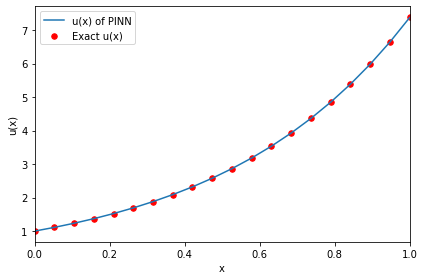

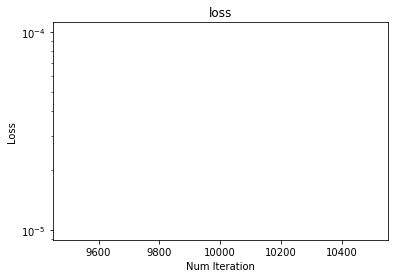

It: 10001, Loss: 1.616e-05
It: 10002, Loss: 1.616e-05
It: 10003, Loss: 1.615e-05
It: 10004, Loss: 1.615e-05
It: 10005, Loss: 1.614e-05
It: 10006, Loss: 1.613e-05
It: 10007, Loss: 1.613e-05
It: 10008, Loss: 1.612e-05
It: 10009, Loss: 1.612e-05
It: 10010, Loss: 1.611e-05
It: 10011, Loss: 1.611e-05
It: 10012, Loss: 1.610e-05
It: 10013, Loss: 1.610e-05
It: 10014, Loss: 1.610e-05
It: 10015, Loss: 1.609e-05
It: 10016, Loss: 1.610e-05
It: 10017, Loss: 1.610e-05
It: 10018, Loss: 1.611e-05
It: 10019, Loss: 1.613e-05
It: 10020, Loss: 1.616e-05
It: 10021, Loss: 1.621e-05
It: 10022, Loss: 1.628e-05
It: 10023, Loss: 1.638e-05
It: 10024, Loss: 1.655e-05
It: 10025, Loss: 1.681e-05
It: 10026, Loss: 1.721e-05
It: 10027, Loss: 1.783e-05
It: 10028, Loss: 1.880e-05
It: 10029, Loss: 2.032e-05
It: 10030, Loss: 2.273e-05
It: 10031, Loss: 2.655e-05
It: 10032, Loss: 3.269e-05
It: 10033, Loss: 4.258e-05
It: 10034, Loss: 5.866e-05
It: 10035, Loss: 8.482e-05
It: 10036, Loss: 1.279e-04
It: 10037, Loss: 1.984e-04
I

It: 10305, Loss: 1.340e-03
It: 10306, Loss: 1.339e-04
It: 10307, Loss: 1.791e-03
It: 10308, Loss: 4.069e-03
It: 10309, Loss: 4.613e-03
It: 10310, Loss: 2.843e-03
It: 10311, Loss: 6.827e-04
It: 10312, Loss: 1.472e-04
It: 10313, Loss: 1.293e-03
It: 10314, Loss: 2.433e-03
It: 10315, Loss: 2.158e-03
It: 10316, Loss: 8.884e-04
It: 10317, Loss: 6.848e-05
It: 10318, Loss: 4.266e-04
It: 10319, Loss: 1.230e-03
It: 10320, Loss: 1.369e-03
It: 10321, Loss: 7.198e-04
It: 10322, Loss: 9.319e-05
It: 10323, Loss: 1.527e-04
It: 10324, Loss: 6.360e-04
It: 10325, Loss: 8.323e-04
It: 10326, Loss: 5.116e-04
It: 10327, Loss: 9.727e-05
It: 10328, Loss: 5.867e-05
It: 10329, Loss: 3.329e-04
It: 10330, Loss: 4.993e-04
It: 10331, Loss: 3.501e-04
It: 10332, Loss: 9.149e-05
It: 10333, Loss: 2.679e-05
It: 10334, Loss: 1.726e-04
It: 10335, Loss: 2.956e-04
It: 10336, Loss: 2.374e-04
It: 10337, Loss: 8.377e-05
It: 10338, Loss: 1.884e-05
It: 10339, Loss: 8.760e-05
It: 10340, Loss: 1.716e-04
It: 10341, Loss: 1.601e-04
I

It: 10609, Loss: 2.695e-05
It: 10610, Loss: 8.887e-05
It: 10611, Loss: 1.254e-04
It: 10612, Loss: 9.618e-05
It: 10613, Loss: 4.725e-05
It: 10614, Loss: 2.992e-05
It: 10615, Loss: 4.381e-05
It: 10616, Loss: 6.016e-05
It: 10617, Loss: 6.324e-05
It: 10618, Loss: 5.469e-05
It: 10619, Loss: 3.976e-05
It: 10620, Loss: 2.664e-05
It: 10621, Loss: 2.558e-05
It: 10622, Loss: 3.716e-05
It: 10623, Loss: 4.702e-05
It: 10624, Loss: 4.146e-05
It: 10625, Loss: 2.545e-05
It: 10626, Loss: 1.643e-05
It: 10627, Loss: 2.214e-05
It: 10628, Loss: 3.238e-05
It: 10629, Loss: 3.400e-05
It: 10630, Loss: 2.659e-05
It: 10631, Loss: 1.934e-05
It: 10632, Loss: 1.828e-05
It: 10633, Loss: 2.131e-05
It: 10634, Loss: 2.374e-05
It: 10635, Loss: 2.378e-05
It: 10636, Loss: 2.219e-05
It: 10637, Loss: 1.992e-05
It: 10638, Loss: 1.788e-05
It: 10639, Loss: 1.738e-05
It: 10640, Loss: 1.889e-05
It: 10641, Loss: 2.072e-05
It: 10642, Loss: 2.063e-05
It: 10643, Loss: 1.846e-05
It: 10644, Loss: 1.641e-05
It: 10645, Loss: 1.629e-05
I

It: 10913, Loss: 1.567e-05
It: 10914, Loss: 1.581e-05
It: 10915, Loss: 1.591e-05
It: 10916, Loss: 1.589e-05
It: 10917, Loss: 1.576e-05
It: 10918, Loss: 1.563e-05
It: 10919, Loss: 1.557e-05
It: 10920, Loss: 1.560e-05
It: 10921, Loss: 1.567e-05
It: 10922, Loss: 1.570e-05
It: 10923, Loss: 1.567e-05
It: 10924, Loss: 1.560e-05
It: 10925, Loss: 1.554e-05
It: 10926, Loss: 1.551e-05
It: 10927, Loss: 1.552e-05
It: 10928, Loss: 1.555e-05
It: 10929, Loss: 1.556e-05
It: 10930, Loss: 1.555e-05
It: 10931, Loss: 1.551e-05
It: 10932, Loss: 1.547e-05
It: 10933, Loss: 1.545e-05
It: 10934, Loss: 1.545e-05
It: 10935, Loss: 1.546e-05
It: 10936, Loss: 1.546e-05
It: 10937, Loss: 1.546e-05
It: 10938, Loss: 1.544e-05
It: 10939, Loss: 1.542e-05
It: 10940, Loss: 1.540e-05
It: 10941, Loss: 1.539e-05
It: 10942, Loss: 1.539e-05
It: 10943, Loss: 1.538e-05
It: 10944, Loss: 1.538e-05
It: 10945, Loss: 1.538e-05
It: 10946, Loss: 1.536e-05
It: 10947, Loss: 1.535e-05
It: 10948, Loss: 1.534e-05
It: 10949, Loss: 1.533e-05
I

It: 11217, Loss: 1.506e-05
It: 11218, Loss: 1.505e-05
It: 11219, Loss: 1.504e-05
It: 11220, Loss: 1.504e-05
It: 11221, Loss: 1.503e-05
It: 11222, Loss: 1.503e-05
It: 11223, Loss: 1.502e-05
It: 11224, Loss: 1.501e-05
It: 11225, Loss: 1.500e-05
It: 11226, Loss: 1.499e-05
It: 11227, Loss: 1.499e-05
It: 11228, Loss: 1.498e-05
It: 11229, Loss: 1.498e-05
It: 11230, Loss: 1.497e-05
It: 11231, Loss: 1.496e-05
It: 11232, Loss: 1.495e-05
It: 11233, Loss: 1.494e-05
It: 11234, Loss: 1.494e-05
It: 11235, Loss: 1.493e-05
It: 11236, Loss: 1.492e-05
It: 11237, Loss: 1.492e-05
It: 11238, Loss: 1.491e-05
It: 11239, Loss: 1.490e-05
It: 11240, Loss: 1.490e-05
It: 11241, Loss: 1.489e-05
It: 11242, Loss: 1.488e-05
It: 11243, Loss: 1.488e-05
It: 11244, Loss: 1.487e-05
It: 11245, Loss: 1.486e-05
It: 11246, Loss: 1.486e-05
It: 11247, Loss: 1.485e-05
It: 11248, Loss: 1.484e-05
It: 11249, Loss: 1.484e-05
It: 11250, Loss: 1.483e-05
It: 11251, Loss: 1.482e-05
It: 11252, Loss: 1.482e-05
It: 11253, Loss: 1.481e-05
I

It: 11521, Loss: 1.451e-05
It: 11522, Loss: 1.450e-05
It: 11523, Loss: 1.450e-05
It: 11524, Loss: 1.449e-05
It: 11525, Loss: 1.448e-05
It: 11526, Loss: 1.448e-05
It: 11527, Loss: 1.447e-05
It: 11528, Loss: 1.447e-05
It: 11529, Loss: 1.446e-05
It: 11530, Loss: 1.445e-05
It: 11531, Loss: 1.445e-05
It: 11532, Loss: 1.444e-05
It: 11533, Loss: 1.443e-05
It: 11534, Loss: 1.443e-05
It: 11535, Loss: 1.442e-05
It: 11536, Loss: 1.441e-05
It: 11537, Loss: 1.441e-05
It: 11538, Loss: 1.440e-05
It: 11539, Loss: 1.440e-05
It: 11540, Loss: 1.439e-05
It: 11541, Loss: 1.438e-05
It: 11542, Loss: 1.438e-05
It: 11543, Loss: 1.437e-05
It: 11544, Loss: 1.437e-05
It: 11545, Loss: 1.436e-05
It: 11546, Loss: 1.435e-05
It: 11547, Loss: 1.435e-05
It: 11548, Loss: 1.434e-05
It: 11549, Loss: 1.434e-05
It: 11550, Loss: 1.433e-05
It: 11551, Loss: 1.433e-05
It: 11552, Loss: 1.432e-05
It: 11553, Loss: 1.431e-05
It: 11554, Loss: 1.431e-05
It: 11555, Loss: 1.430e-05
It: 11556, Loss: 1.430e-05
It: 11557, Loss: 1.429e-05
I

It: 11825, Loss: 1.395e-05
It: 11826, Loss: 1.395e-05
It: 11827, Loss: 1.394e-05
It: 11828, Loss: 1.394e-05
It: 11829, Loss: 1.393e-05
It: 11830, Loss: 1.392e-05
It: 11831, Loss: 1.392e-05
It: 11832, Loss: 1.391e-05
It: 11833, Loss: 1.391e-05
It: 11834, Loss: 1.390e-05
It: 11835, Loss: 1.390e-05
It: 11836, Loss: 1.389e-05
It: 11837, Loss: 1.389e-05
It: 11838, Loss: 1.388e-05
It: 11839, Loss: 1.388e-05
It: 11840, Loss: 1.387e-05
It: 11841, Loss: 1.387e-05
It: 11842, Loss: 1.386e-05
It: 11843, Loss: 1.386e-05
It: 11844, Loss: 1.386e-05
It: 11845, Loss: 1.386e-05
It: 11846, Loss: 1.386e-05
It: 11847, Loss: 1.387e-05
It: 11848, Loss: 1.389e-05
It: 11849, Loss: 1.391e-05
It: 11850, Loss: 1.395e-05
It: 11851, Loss: 1.402e-05
It: 11852, Loss: 1.414e-05
It: 11853, Loss: 1.433e-05
It: 11854, Loss: 1.463e-05
It: 11855, Loss: 1.513e-05
It: 11856, Loss: 1.596e-05
It: 11857, Loss: 1.732e-05
It: 11858, Loss: 1.957e-05
It: 11859, Loss: 2.334e-05
It: 11860, Loss: 2.967e-05
It: 11861, Loss: 4.039e-05
I

It: 12129, Loss: 1.360e-05
It: 12130, Loss: 1.362e-05
It: 12131, Loss: 1.364e-05
It: 12132, Loss: 1.368e-05
It: 12133, Loss: 1.375e-05
It: 12134, Loss: 1.385e-05
It: 12135, Loss: 1.401e-05
It: 12136, Loss: 1.426e-05
It: 12137, Loss: 1.465e-05
It: 12138, Loss: 1.528e-05
It: 12139, Loss: 1.626e-05
It: 12140, Loss: 1.784e-05
It: 12141, Loss: 2.038e-05
It: 12142, Loss: 2.450e-05
It: 12143, Loss: 3.124e-05
It: 12144, Loss: 4.227e-05
It: 12145, Loss: 6.052e-05
It: 12146, Loss: 9.076e-05
It: 12147, Loss: 1.414e-04
It: 12148, Loss: 2.258e-04
It: 12149, Loss: 3.683e-04
It: 12150, Loss: 6.056e-04
It: 12151, Loss: 1.004e-03
It: 12152, Loss: 1.652e-03
It: 12153, Loss: 2.699e-03
It: 12154, Loss: 4.247e-03
It: 12155, Loss: 6.409e-03
It: 12156, Loss: 8.728e-03
It: 12157, Loss: 1.049e-02
It: 12158, Loss: 9.974e-03
It: 12159, Loss: 6.963e-03
It: 12160, Loss: 2.736e-03
It: 12161, Loss: 2.538e-04
It: 12162, Loss: 7.927e-04
It: 12163, Loss: 3.030e-03
It: 12164, Loss: 4.491e-03
It: 12165, Loss: 3.636e-03
I

It: 12433, Loss: 3.382e-03
It: 12434, Loss: 5.598e-03
It: 12435, Loss: 8.524e-03
It: 12436, Loss: 1.172e-02
It: 12437, Loss: 1.310e-02
It: 12438, Loss: 1.130e-02
It: 12439, Loss: 6.213e-03
It: 12440, Loss: 1.701e-03
It: 12441, Loss: 8.409e-04
It: 12442, Loss: 3.144e-03
It: 12443, Loss: 5.346e-03
It: 12444, Loss: 4.797e-03
It: 12445, Loss: 2.301e-03
It: 12446, Loss: 5.540e-04
It: 12447, Loss: 1.125e-03
It: 12448, Loss: 2.668e-03
It: 12449, Loss: 2.875e-03
It: 12450, Loss: 1.459e-03
It: 12451, Loss: 2.309e-04
It: 12452, Loss: 6.416e-04
It: 12453, Loss: 1.726e-03
It: 12454, Loss: 1.690e-03
It: 12455, Loss: 6.029e-04
It: 12456, Loss: 3.560e-05
It: 12457, Loss: 6.166e-04
It: 12458, Loss: 1.200e-03
It: 12459, Loss: 8.192e-04
It: 12460, Loss: 1.334e-04
It: 12461, Loss: 1.269e-04
It: 12462, Loss: 5.870e-04
It: 12463, Loss: 6.809e-04
It: 12464, Loss: 3.085e-04
It: 12465, Loss: 7.065e-05
It: 12466, Loss: 2.125e-04
It: 12467, Loss: 3.906e-04
It: 12468, Loss: 3.269e-04
It: 12469, Loss: 1.510e-04
I

It: 12737, Loss: 1.984e-04
It: 12738, Loss: 3.177e-04
It: 12739, Loss: 5.135e-04
It: 12740, Loss: 8.381e-04
It: 12741, Loss: 1.361e-03
It: 12742, Loss: 2.201e-03
It: 12743, Loss: 3.453e-03
It: 12744, Loss: 5.248e-03
It: 12745, Loss: 7.328e-03
It: 12746, Loss: 9.256e-03
It: 12747, Loss: 9.618e-03
It: 12748, Loss: 7.798e-03
It: 12749, Loss: 4.075e-03
It: 12750, Loss: 8.858e-04
It: 12751, Loss: 1.404e-04
It: 12752, Loss: 1.699e-03
It: 12753, Loss: 3.647e-03
It: 12754, Loss: 3.980e-03
It: 12755, Loss: 2.472e-03
It: 12756, Loss: 5.907e-04
It: 12757, Loss: 8.226e-05
It: 12758, Loss: 1.033e-03
It: 12759, Loss: 2.058e-03
It: 12760, Loss: 1.966e-03
It: 12761, Loss: 8.996e-04
It: 12762, Loss: 7.619e-05
It: 12763, Loss: 2.396e-04
It: 12764, Loss: 9.374e-04
It: 12765, Loss: 1.227e-03
It: 12766, Loss: 7.775e-04
It: 12767, Loss: 1.661e-04
It: 12768, Loss: 4.550e-05
It: 12769, Loss: 4.041e-04
It: 12770, Loss: 7.000e-04
It: 12771, Loss: 5.645e-04
It: 12772, Loss: 1.962e-04
It: 12773, Loss: 1.859e-05
I

It: 13041, Loss: 2.851e-04
It: 13042, Loss: 1.942e-04
It: 13043, Loss: 5.075e-05
It: 13044, Loss: 2.339e-05
It: 13045, Loss: 1.089e-04
It: 13046, Loss: 1.707e-04
It: 13047, Loss: 1.295e-04
It: 13048, Loss: 4.701e-05
It: 13049, Loss: 2.034e-05
It: 13050, Loss: 6.048e-05
It: 13051, Loss: 9.941e-05
It: 13052, Loss: 8.703e-05
It: 13053, Loss: 4.442e-05
It: 13054, Loss: 2.154e-05
It: 13055, Loss: 3.453e-05
It: 13056, Loss: 5.662e-05
It: 13057, Loss: 5.845e-05
It: 13058, Loss: 4.036e-05
It: 13059, Loss: 2.357e-05
It: 13060, Loss: 2.263e-05
It: 13061, Loss: 3.241e-05
It: 13062, Loss: 3.869e-05
It: 13063, Loss: 3.455e-05
It: 13064, Loss: 2.479e-05
It: 13065, Loss: 1.869e-05
It: 13066, Loss: 2.027e-05
It: 13067, Loss: 2.560e-05
It: 13068, Loss: 2.783e-05
It: 13069, Loss: 2.421e-05
It: 13070, Loss: 1.833e-05
It: 13071, Loss: 1.569e-05
It: 13072, Loss: 1.793e-05
It: 13073, Loss: 2.152e-05
It: 13074, Loss: 2.196e-05
It: 13075, Loss: 1.863e-05
It: 13076, Loss: 1.500e-05
It: 13077, Loss: 1.450e-05
I

It: 13345, Loss: 2.370e-05
It: 13346, Loss: 2.634e-05
It: 13347, Loss: 2.147e-05
It: 13348, Loss: 1.524e-05
It: 13349, Loss: 1.412e-05
It: 13350, Loss: 1.775e-05
It: 13351, Loss: 2.078e-05
It: 13352, Loss: 1.962e-05
It: 13353, Loss: 1.595e-05
It: 13354, Loss: 1.380e-05
It: 13355, Loss: 1.480e-05
It: 13356, Loss: 1.698e-05
It: 13357, Loss: 1.755e-05
It: 13358, Loss: 1.603e-05
It: 13359, Loss: 1.418e-05
It: 13360, Loss: 1.377e-05
It: 13361, Loss: 1.473e-05
It: 13362, Loss: 1.566e-05
It: 13363, Loss: 1.550e-05
It: 13364, Loss: 1.450e-05
It: 13365, Loss: 1.371e-05
It: 13366, Loss: 1.374e-05
It: 13367, Loss: 1.431e-05
It: 13368, Loss: 1.466e-05
It: 13369, Loss: 1.443e-05
It: 13370, Loss: 1.389e-05
It: 13371, Loss: 1.354e-05
It: 13372, Loss: 1.361e-05
It: 13373, Loss: 1.390e-05
It: 13374, Loss: 1.404e-05
It: 13375, Loss: 1.390e-05
It: 13376, Loss: 1.362e-05
It: 13377, Loss: 1.344e-05
It: 13378, Loss: 1.347e-05
It: 13379, Loss: 1.361e-05
It: 13380, Loss: 1.368e-05
It: 13381, Loss: 1.361e-05
I

It: 13648, Loss: 1.548e-05
It: 13649, Loss: 1.512e-05
It: 13650, Loss: 1.402e-05
It: 13651, Loss: 1.329e-05
It: 13652, Loss: 1.347e-05
It: 13653, Loss: 1.413e-05
It: 13654, Loss: 1.445e-05
It: 13655, Loss: 1.411e-05
It: 13656, Loss: 1.351e-05
It: 13657, Loss: 1.319e-05
It: 13658, Loss: 1.335e-05
It: 13659, Loss: 1.370e-05
It: 13660, Loss: 1.382e-05
It: 13661, Loss: 1.361e-05
It: 13662, Loss: 1.328e-05
It: 13663, Loss: 1.312e-05
It: 13664, Loss: 1.321e-05
It: 13665, Loss: 1.339e-05
It: 13666, Loss: 1.346e-05
It: 13667, Loss: 1.335e-05
It: 13668, Loss: 1.317e-05
It: 13669, Loss: 1.307e-05
It: 13670, Loss: 1.309e-05
It: 13671, Loss: 1.319e-05
It: 13672, Loss: 1.323e-05
It: 13673, Loss: 1.318e-05
It: 13674, Loss: 1.308e-05
It: 13675, Loss: 1.301e-05
It: 13676, Loss: 1.301e-05
It: 13677, Loss: 1.305e-05
It: 13678, Loss: 1.308e-05
It: 13679, Loss: 1.307e-05
It: 13680, Loss: 1.302e-05
It: 13681, Loss: 1.297e-05
It: 13682, Loss: 1.295e-05
It: 13683, Loss: 1.296e-05
It: 13684, Loss: 1.298e-05
I

It: 13952, Loss: 2.403e-05
It: 13953, Loss: 2.986e-05
It: 13954, Loss: 3.874e-05
It: 13955, Loss: 5.238e-05
It: 13956, Loss: 7.340e-05
It: 13957, Loss: 1.062e-04
It: 13958, Loss: 1.571e-04
It: 13959, Loss: 2.374e-04
It: 13960, Loss: 3.626e-04
It: 13961, Loss: 5.604e-04
It: 13962, Loss: 8.658e-04
It: 13963, Loss: 1.340e-03
It: 13964, Loss: 2.040e-03
It: 13965, Loss: 3.057e-03
It: 13966, Loss: 4.358e-03
It: 13967, Loss: 5.883e-03
It: 13968, Loss: 7.070e-03
It: 13969, Loss: 7.406e-03
It: 13970, Loss: 6.098e-03
It: 13971, Loss: 3.620e-03
It: 13972, Loss: 1.121e-03
It: 13973, Loss: 2.381e-05
It: 13974, Loss: 6.238e-04
It: 13975, Loss: 2.028e-03
It: 13976, Loss: 2.961e-03
It: 13977, Loss: 2.614e-03
It: 13978, Loss: 1.363e-03
It: 13979, Loss: 2.424e-04
It: 13980, Loss: 7.772e-05
It: 13981, Loss: 7.336e-04
It: 13982, Loss: 1.401e-03
It: 13983, Loss: 1.426e-03
It: 13984, Loss: 8.121e-04
It: 13985, Loss: 1.738e-04
It: 13986, Loss: 3.556e-05
It: 13987, Loss: 3.778e-04
It: 13988, Loss: 7.503e-04
I

It: 14256, Loss: 2.583e-05
It: 14257, Loss: 1.555e-05
It: 14258, Loss: 1.414e-05
It: 14259, Loss: 2.057e-05
It: 14260, Loss: 2.540e-05
It: 14261, Loss: 2.282e-05
It: 14262, Loss: 1.634e-05
It: 14263, Loss: 1.313e-05
It: 14264, Loss: 1.552e-05
It: 14265, Loss: 1.936e-05
It: 14266, Loss: 1.980e-05
It: 14267, Loss: 1.658e-05
It: 14268, Loss: 1.345e-05
It: 14269, Loss: 1.337e-05
It: 14270, Loss: 1.555e-05
It: 14271, Loss: 1.701e-05
It: 14272, Loss: 1.611e-05
It: 14273, Loss: 1.402e-05
It: 14274, Loss: 1.291e-05
It: 14275, Loss: 1.356e-05
It: 14276, Loss: 1.480e-05
It: 14277, Loss: 1.511e-05
It: 14278, Loss: 1.424e-05
It: 14279, Loss: 1.315e-05
It: 14280, Loss: 1.287e-05
It: 14281, Loss: 1.340e-05
It: 14282, Loss: 1.399e-05
It: 14283, Loss: 1.396e-05
It: 14284, Loss: 1.340e-05
It: 14285, Loss: 1.287e-05
It: 14286, Loss: 1.282e-05
It: 14287, Loss: 1.313e-05
It: 14288, Loss: 1.340e-05
It: 14289, Loss: 1.334e-05
It: 14290, Loss: 1.302e-05
It: 14291, Loss: 1.275e-05
It: 14292, Loss: 1.274e-05
I

It: 14560, Loss: 1.464e-05
It: 14561, Loss: 1.344e-05
It: 14562, Loss: 1.269e-05
It: 14563, Loss: 1.294e-05
It: 14564, Loss: 1.368e-05
It: 14565, Loss: 1.403e-05
It: 14566, Loss: 1.363e-05
It: 14567, Loss: 1.290e-05
It: 14568, Loss: 1.251e-05
It: 14569, Loss: 1.269e-05
It: 14570, Loss: 1.312e-05
It: 14571, Loss: 1.330e-05
It: 14572, Loss: 1.306e-05
It: 14573, Loss: 1.266e-05
It: 14574, Loss: 1.244e-05
It: 14575, Loss: 1.252e-05
It: 14576, Loss: 1.274e-05
It: 14577, Loss: 1.283e-05
It: 14578, Loss: 1.273e-05
It: 14579, Loss: 1.253e-05
It: 14580, Loss: 1.240e-05
It: 14581, Loss: 1.241e-05
It: 14582, Loss: 1.249e-05
It: 14583, Loss: 1.255e-05
It: 14584, Loss: 1.253e-05
It: 14585, Loss: 1.244e-05
It: 14586, Loss: 1.236e-05
It: 14587, Loss: 1.233e-05
It: 14588, Loss: 1.234e-05
It: 14589, Loss: 1.237e-05
It: 14590, Loss: 1.238e-05
It: 14591, Loss: 1.236e-05
It: 14592, Loss: 1.232e-05
It: 14593, Loss: 1.228e-05
It: 14594, Loss: 1.226e-05
It: 14595, Loss: 1.226e-05
It: 14596, Loss: 1.227e-05
I

It: 14864, Loss: 1.210e-05
It: 14865, Loss: 1.212e-05
It: 14866, Loss: 1.214e-05
It: 14867, Loss: 1.214e-05
It: 14868, Loss: 1.211e-05
It: 14869, Loss: 1.207e-05
It: 14870, Loss: 1.204e-05
It: 14871, Loss: 1.204e-05
It: 14872, Loss: 1.204e-05
It: 14873, Loss: 1.205e-05
It: 14874, Loss: 1.205e-05
It: 14875, Loss: 1.203e-05
It: 14876, Loss: 1.200e-05
It: 14877, Loss: 1.199e-05
It: 14878, Loss: 1.198e-05
It: 14879, Loss: 1.198e-05
It: 14880, Loss: 1.198e-05
It: 14881, Loss: 1.197e-05
It: 14882, Loss: 1.196e-05
It: 14883, Loss: 1.195e-05
It: 14884, Loss: 1.193e-05
It: 14885, Loss: 1.192e-05
It: 14886, Loss: 1.192e-05
It: 14887, Loss: 1.191e-05
It: 14888, Loss: 1.191e-05
It: 14889, Loss: 1.190e-05
It: 14890, Loss: 1.189e-05
It: 14891, Loss: 1.188e-05
It: 14892, Loss: 1.187e-05
It: 14893, Loss: 1.186e-05
It: 14894, Loss: 1.186e-05
It: 14895, Loss: 1.185e-05
It: 14896, Loss: 1.185e-05
It: 14897, Loss: 1.184e-05
It: 14898, Loss: 1.183e-05
It: 14899, Loss: 1.182e-05
It: 14900, Loss: 1.182e-05
I

It: 15168, Loss: 8.876e-05
It: 15169, Loss: 3.755e-05
It: 15170, Loss: 1.285e-05
It: 15171, Loss: 2.045e-05
It: 15172, Loss: 4.724e-05
It: 15173, Loss: 7.247e-05
It: 15174, Loss: 8.048e-05
It: 15175, Loss: 6.850e-05
It: 15176, Loss: 4.490e-05
It: 15177, Loss: 2.293e-05
It: 15178, Loss: 1.233e-05
It: 15179, Loss: 1.516e-05
It: 15180, Loss: 2.630e-05
It: 15181, Loss: 3.755e-05
It: 15182, Loss: 4.246e-05
It: 15183, Loss: 3.903e-05
It: 15184, Loss: 2.988e-05
It: 15185, Loss: 1.981e-05
It: 15186, Loss: 1.322e-05
It: 15187, Loss: 1.197e-05
It: 15188, Loss: 1.517e-05
It: 15189, Loss: 2.012e-05
It: 15190, Loss: 2.391e-05
It: 15191, Loss: 2.481e-05
It: 15192, Loss: 2.268e-05
It: 15193, Loss: 1.879e-05
It: 15194, Loss: 1.486e-05
It: 15195, Loss: 1.231e-05
It: 15196, Loss: 1.173e-05
It: 15197, Loss: 1.281e-05
It: 15198, Loss: 1.464e-05
It: 15199, Loss: 1.626e-05
It: 15200, Loss: 1.697e-05
It: 15201, Loss: 1.660e-05
It: 15202, Loss: 1.539e-05
It: 15203, Loss: 1.386e-05
It: 15204, Loss: 1.254e-05
I

It: 15472, Loss: 1.142e-05
It: 15473, Loss: 1.141e-05
It: 15474, Loss: 1.141e-05
It: 15475, Loss: 1.140e-05
It: 15476, Loss: 1.139e-05
It: 15477, Loss: 1.139e-05
It: 15478, Loss: 1.138e-05
It: 15479, Loss: 1.138e-05
It: 15480, Loss: 1.137e-05
It: 15481, Loss: 1.136e-05
It: 15482, Loss: 1.136e-05
It: 15483, Loss: 1.135e-05
It: 15484, Loss: 1.134e-05
It: 15485, Loss: 1.134e-05
It: 15486, Loss: 1.133e-05
It: 15487, Loss: 1.132e-05
It: 15488, Loss: 1.132e-05
It: 15489, Loss: 1.131e-05
It: 15490, Loss: 1.131e-05
It: 15491, Loss: 1.130e-05
It: 15492, Loss: 1.129e-05
It: 15493, Loss: 1.129e-05
It: 15494, Loss: 1.128e-05
It: 15495, Loss: 1.128e-05
It: 15496, Loss: 1.127e-05
It: 15497, Loss: 1.126e-05
It: 15498, Loss: 1.126e-05
It: 15499, Loss: 1.125e-05
It: 15500, Loss: 1.125e-05
It: 15501, Loss: 1.124e-05
It: 15502, Loss: 1.123e-05
It: 15503, Loss: 1.123e-05
It: 15504, Loss: 1.122e-05
It: 15505, Loss: 1.122e-05
It: 15506, Loss: 1.121e-05
It: 15507, Loss: 1.121e-05
It: 15508, Loss: 1.120e-05
I

It: 15776, Loss: 1.102e-05
It: 15777, Loss: 1.102e-05
It: 15778, Loss: 1.101e-05
It: 15779, Loss: 1.101e-05
It: 15780, Loss: 1.100e-05
It: 15781, Loss: 1.100e-05
It: 15782, Loss: 1.099e-05
It: 15783, Loss: 1.099e-05
It: 15784, Loss: 1.098e-05
It: 15785, Loss: 1.098e-05
It: 15786, Loss: 1.097e-05
It: 15787, Loss: 1.096e-05
It: 15788, Loss: 1.096e-05
It: 15789, Loss: 1.095e-05
It: 15790, Loss: 1.095e-05
It: 15791, Loss: 1.094e-05
It: 15792, Loss: 1.094e-05
It: 15793, Loss: 1.093e-05
It: 15794, Loss: 1.093e-05
It: 15795, Loss: 1.092e-05
It: 15796, Loss: 1.092e-05
It: 15797, Loss: 1.091e-05
It: 15798, Loss: 1.091e-05
It: 15799, Loss: 1.090e-05
It: 15800, Loss: 1.090e-05
It: 15801, Loss: 1.089e-05
It: 15802, Loss: 1.089e-05
It: 15803, Loss: 1.088e-05
It: 15804, Loss: 1.088e-05
It: 15805, Loss: 1.087e-05
It: 15806, Loss: 1.087e-05
It: 15807, Loss: 1.086e-05
It: 15808, Loss: 1.086e-05
It: 15809, Loss: 1.085e-05
It: 15810, Loss: 1.085e-05
It: 15811, Loss: 1.085e-05
It: 15812, Loss: 1.084e-05
I

It: 16080, Loss: 1.068e-05
It: 16081, Loss: 1.067e-05
It: 16082, Loss: 1.067e-05
It: 16083, Loss: 1.067e-05
It: 16084, Loss: 1.066e-05
It: 16085, Loss: 1.066e-05
It: 16086, Loss: 1.065e-05
It: 16087, Loss: 1.065e-05
It: 16088, Loss: 1.065e-05
It: 16089, Loss: 1.064e-05
It: 16090, Loss: 1.064e-05
It: 16091, Loss: 1.064e-05
It: 16092, Loss: 1.063e-05
It: 16093, Loss: 1.063e-05
It: 16094, Loss: 1.063e-05
It: 16095, Loss: 1.064e-05
It: 16096, Loss: 1.064e-05
It: 16097, Loss: 1.066e-05
It: 16098, Loss: 1.068e-05
It: 16099, Loss: 1.071e-05
It: 16100, Loss: 1.076e-05
It: 16101, Loss: 1.083e-05
It: 16102, Loss: 1.095e-05
It: 16103, Loss: 1.113e-05
It: 16104, Loss: 1.142e-05
It: 16105, Loss: 1.186e-05
It: 16106, Loss: 1.256e-05
It: 16107, Loss: 1.365e-05
It: 16108, Loss: 1.540e-05
It: 16109, Loss: 1.819e-05
It: 16110, Loss: 2.268e-05
It: 16111, Loss: 2.995e-05
It: 16112, Loss: 4.183e-05
It: 16113, Loss: 6.124e-05
It: 16114, Loss: 9.328e-05
It: 16115, Loss: 1.459e-04
It: 16116, Loss: 2.333e-04
I

It: 16384, Loss: 2.298e-05
It: 16385, Loss: 1.826e-04
It: 16386, Loss: 5.437e-04
It: 16387, Loss: 6.203e-04
It: 16388, Loss: 3.444e-04
It: 16389, Loss: 5.513e-05
It: 16390, Loss: 5.147e-05
It: 16391, Loss: 2.560e-04
It: 16392, Loss: 3.742e-04
It: 16393, Loss: 2.690e-04
It: 16394, Loss: 7.881e-05
It: 16395, Loss: 1.516e-05
It: 16396, Loss: 1.086e-04
It: 16397, Loss: 2.107e-04
It: 16398, Loss: 1.941e-04
It: 16399, Loss: 8.751e-05
It: 16400, Loss: 1.524e-05
It: 16401, Loss: 4.024e-05
It: 16402, Loss: 1.082e-04
It: 16403, Loss: 1.298e-04
It: 16404, Loss: 8.331e-05
It: 16405, Loss: 2.580e-05
It: 16406, Loss: 1.542e-05
It: 16407, Loss: 4.938e-05
It: 16408, Loss: 7.877e-05
It: 16409, Loss: 6.924e-05
It: 16410, Loss: 3.468e-05
It: 16411, Loss: 1.275e-05
It: 16412, Loss: 2.106e-05
It: 16413, Loss: 4.263e-05
It: 16414, Loss: 5.027e-05
It: 16415, Loss: 3.675e-05
It: 16416, Loss: 1.797e-05
It: 16417, Loss: 1.226e-05
It: 16418, Loss: 2.131e-05
It: 16419, Loss: 3.188e-05
It: 16420, Loss: 3.194e-05
I

It: 16688, Loss: 1.306e-05
It: 16689, Loss: 1.148e-05
It: 16690, Loss: 1.236e-05
It: 16691, Loss: 1.421e-05
It: 16692, Loss: 1.498e-05
It: 16693, Loss: 1.401e-05
It: 16694, Loss: 1.234e-05
It: 16695, Loss: 1.140e-05
It: 16696, Loss: 1.172e-05
It: 16697, Loss: 1.267e-05
It: 16698, Loss: 1.320e-05
It: 16699, Loss: 1.284e-05
It: 16700, Loss: 1.198e-05
It: 16701, Loss: 1.134e-05
It: 16702, Loss: 1.134e-05
It: 16703, Loss: 1.178e-05
It: 16704, Loss: 1.216e-05
It: 16705, Loss: 1.213e-05
It: 16706, Loss: 1.174e-05
It: 16707, Loss: 1.131e-05
It: 16708, Loss: 1.116e-05
It: 16709, Loss: 1.130e-05
It: 16710, Loss: 1.154e-05
It: 16711, Loss: 1.163e-05
It: 16712, Loss: 1.151e-05
It: 16713, Loss: 1.128e-05
It: 16714, Loss: 1.110e-05
It: 16715, Loss: 1.108e-05
It: 16716, Loss: 1.118e-05
It: 16717, Loss: 1.128e-05
It: 16718, Loss: 1.129e-05
It: 16719, Loss: 1.120e-05
It: 16720, Loss: 1.108e-05
It: 16721, Loss: 1.100e-05
It: 16722, Loss: 1.100e-05
It: 16723, Loss: 1.105e-05
It: 16724, Loss: 1.109e-05
I

It: 16992, Loss: 1.078e-05
It: 16993, Loss: 1.078e-05
It: 16994, Loss: 1.077e-05
It: 16995, Loss: 1.075e-05
It: 16996, Loss: 1.073e-05
It: 16997, Loss: 1.071e-05
It: 16998, Loss: 1.071e-05
It: 16999, Loss: 1.070e-05
It: 17000, Loss: 1.070e-05
It: 17001, Loss: 1.069e-05
It: 17002, Loss: 1.068e-05
It: 17003, Loss: 1.067e-05
It: 17004, Loss: 1.065e-05
It: 17005, Loss: 1.065e-05
It: 17006, Loss: 1.064e-05
It: 17007, Loss: 1.063e-05
It: 17008, Loss: 1.062e-05
It: 17009, Loss: 1.062e-05
It: 17010, Loss: 1.061e-05
It: 17011, Loss: 1.060e-05
It: 17012, Loss: 1.059e-05
It: 17013, Loss: 1.058e-05
It: 17014, Loss: 1.057e-05
It: 17015, Loss: 1.057e-05
It: 17016, Loss: 1.056e-05
It: 17017, Loss: 1.055e-05
It: 17018, Loss: 1.055e-05
It: 17019, Loss: 1.054e-05
It: 17020, Loss: 1.053e-05
It: 17021, Loss: 1.052e-05
It: 17022, Loss: 1.051e-05
It: 17023, Loss: 1.051e-05
It: 17024, Loss: 1.050e-05
It: 17025, Loss: 1.049e-05
It: 17026, Loss: 1.049e-05
It: 17027, Loss: 1.048e-05
It: 17028, Loss: 1.047e-05
I

It: 17296, Loss: 1.029e-05
It: 17297, Loss: 1.028e-05
It: 17298, Loss: 1.028e-05
It: 17299, Loss: 1.027e-05
It: 17300, Loss: 1.027e-05
It: 17301, Loss: 1.026e-05
It: 17302, Loss: 1.025e-05
It: 17303, Loss: 1.025e-05
It: 17304, Loss: 1.024e-05
It: 17305, Loss: 1.024e-05
It: 17306, Loss: 1.023e-05
It: 17307, Loss: 1.022e-05
It: 17308, Loss: 1.022e-05
It: 17309, Loss: 1.021e-05
It: 17310, Loss: 1.021e-05
It: 17311, Loss: 1.020e-05
It: 17312, Loss: 1.020e-05
It: 17313, Loss: 1.019e-05
It: 17314, Loss: 1.018e-05
It: 17315, Loss: 1.018e-05
It: 17316, Loss: 1.017e-05
It: 17317, Loss: 1.017e-05
It: 17318, Loss: 1.016e-05
It: 17319, Loss: 1.016e-05
It: 17320, Loss: 1.015e-05
It: 17321, Loss: 1.015e-05
It: 17322, Loss: 1.014e-05
It: 17323, Loss: 1.014e-05
It: 17324, Loss: 1.013e-05
It: 17325, Loss: 1.013e-05
It: 17326, Loss: 1.012e-05
It: 17327, Loss: 1.012e-05
It: 17328, Loss: 1.011e-05
It: 17329, Loss: 1.011e-05
It: 17330, Loss: 1.010e-05
It: 17331, Loss: 1.010e-05
It: 17332, Loss: 1.009e-05
I

It: 17600, Loss: 9.987e-06
It: 17601, Loss: 1.001e-05
It: 17602, Loss: 1.003e-05
It: 17603, Loss: 1.008e-05
It: 17604, Loss: 1.015e-05
It: 17605, Loss: 1.025e-05
It: 17606, Loss: 1.041e-05
It: 17607, Loss: 1.067e-05
It: 17608, Loss: 1.106e-05
It: 17609, Loss: 1.168e-05
It: 17610, Loss: 1.266e-05
It: 17611, Loss: 1.420e-05
It: 17612, Loss: 1.666e-05
It: 17613, Loss: 2.060e-05
It: 17614, Loss: 2.693e-05
It: 17615, Loss: 3.715e-05
It: 17616, Loss: 5.370e-05
It: 17617, Loss: 8.042e-05
It: 17618, Loss: 1.234e-04
It: 17619, Loss: 1.915e-04
It: 17620, Loss: 2.970e-04
It: 17621, Loss: 4.522e-04
It: 17622, Loss: 6.650e-04
It: 17623, Loss: 9.180e-04
It: 17624, Loss: 1.164e-03
It: 17625, Loss: 1.309e-03
It: 17626, Loss: 1.321e-03
It: 17627, Loss: 1.240e-03
It: 17628, Loss: 1.256e-03
It: 17629, Loss: 1.472e-03
It: 17630, Loss: 1.864e-03
It: 17631, Loss: 2.185e-03
It: 17632, Loss: 2.239e-03
It: 17633, Loss: 1.901e-03
It: 17634, Loss: 1.405e-03
It: 17635, Loss: 9.771e-04
It: 17636, Loss: 7.218e-04
I

It: 17904, Loss: 5.445e-05
It: 17905, Loss: 2.450e-05
It: 17906, Loss: 1.089e-05
It: 17907, Loss: 1.670e-05
It: 17908, Loss: 3.317e-05
It: 17909, Loss: 4.732e-05
It: 17910, Loss: 5.014e-05
It: 17911, Loss: 4.114e-05
It: 17912, Loss: 2.653e-05
It: 17913, Loss: 1.459e-05
It: 17914, Loss: 1.051e-05
It: 17915, Loss: 1.422e-05
It: 17916, Loss: 2.159e-05
It: 17917, Loss: 2.742e-05
It: 17918, Loss: 2.845e-05
It: 17919, Loss: 2.458e-05
It: 17920, Loss: 1.832e-05
It: 17921, Loss: 1.287e-05
It: 17922, Loss: 1.045e-05
It: 17923, Loss: 1.133e-05
It: 17924, Loss: 1.418e-05
It: 17925, Loss: 1.701e-05
It: 17926, Loss: 1.829e-05
It: 17927, Loss: 1.753e-05
It: 17928, Loss: 1.531e-05
It: 17929, Loss: 1.274e-05
It: 17930, Loss: 1.089e-05
It: 17931, Loss: 1.029e-05
It: 17932, Loss: 1.083e-05
It: 17933, Loss: 1.197e-05
It: 17934, Loss: 1.304e-05
It: 17935, Loss: 1.352e-05
It: 17936, Loss: 1.328e-05
It: 17937, Loss: 1.248e-05
It: 17938, Loss: 1.149e-05
It: 17939, Loss: 1.067e-05
It: 17940, Loss: 1.024e-05
I

It: 18208, Loss: 9.644e-06
It: 18209, Loss: 9.640e-06
It: 18210, Loss: 9.637e-06
It: 18211, Loss: 9.635e-06
It: 18212, Loss: 9.632e-06
It: 18213, Loss: 9.630e-06
It: 18214, Loss: 9.632e-06
It: 18215, Loss: 9.633e-06
It: 18216, Loss: 9.641e-06
It: 18217, Loss: 9.650e-06
It: 18218, Loss: 9.666e-06
It: 18219, Loss: 9.693e-06
It: 18220, Loss: 9.733e-06
It: 18221, Loss: 9.794e-06
It: 18222, Loss: 9.890e-06
It: 18223, Loss: 1.003e-05
It: 18224, Loss: 1.026e-05
It: 18225, Loss: 1.060e-05
It: 18226, Loss: 1.113e-05
It: 18227, Loss: 1.196e-05
It: 18228, Loss: 1.325e-05
It: 18229, Loss: 1.530e-05
It: 18230, Loss: 1.854e-05
It: 18231, Loss: 2.373e-05
It: 18232, Loss: 3.207e-05
It: 18233, Loss: 4.560e-05
It: 18234, Loss: 6.757e-05
It: 18235, Loss: 1.037e-04
It: 18236, Loss: 1.628e-04
It: 18237, Loss: 2.607e-04
It: 18238, Loss: 4.211e-04
It: 18239, Loss: 6.866e-04
It: 18240, Loss: 1.112e-03
It: 18241, Loss: 1.796e-03
It: 18242, Loss: 2.811e-03
It: 18243, Loss: 4.269e-03
It: 18244, Loss: 5.970e-03
I

It: 18512, Loss: 2.115e-03
It: 18513, Loss: 8.672e-04
It: 18514, Loss: 5.905e-05
It: 18515, Loss: 4.505e-04
It: 18516, Loss: 1.229e-03
It: 18517, Loss: 1.277e-03
It: 18518, Loss: 5.630e-04
It: 18519, Loss: 4.089e-05
It: 18520, Loss: 2.521e-04
It: 18521, Loss: 7.265e-04
It: 18522, Loss: 7.602e-04
It: 18523, Loss: 3.304e-04
It: 18524, Loss: 2.269e-05
It: 18525, Loss: 1.609e-04
It: 18526, Loss: 4.458e-04
It: 18527, Loss: 4.527e-04
It: 18528, Loss: 1.894e-04
It: 18529, Loss: 1.444e-05
It: 18530, Loss: 1.073e-04
It: 18531, Loss: 2.760e-04
It: 18532, Loss: 2.718e-04
It: 18533, Loss: 1.125e-04
It: 18534, Loss: 1.238e-05
It: 18535, Loss: 7.083e-05
It: 18536, Loss: 1.701e-04
It: 18537, Loss: 1.660e-04
It: 18538, Loss: 7.201e-05
It: 18539, Loss: 1.278e-05
It: 18540, Loss: 4.567e-05
It: 18541, Loss: 1.039e-04
It: 18542, Loss: 1.039e-04
It: 18543, Loss: 5.042e-05
It: 18544, Loss: 1.361e-05
It: 18545, Loss: 2.932e-05
It: 18546, Loss: 6.327e-05
It: 18547, Loss: 6.692e-05
It: 18548, Loss: 3.820e-05
I

It: 18816, Loss: 1.750e-04
It: 18817, Loss: 2.050e-04
It: 18818, Loss: 4.450e-04
It: 18819, Loss: 4.712e-04
It: 18820, Loss: 1.760e-04
It: 18821, Loss: 1.752e-05
It: 18822, Loss: 2.003e-04
It: 18823, Loss: 3.461e-04
It: 18824, Loss: 2.120e-04
It: 18825, Loss: 4.825e-05
It: 18826, Loss: 7.616e-05
It: 18827, Loss: 1.634e-04
It: 18828, Loss: 1.615e-04
It: 18829, Loss: 1.112e-04
It: 18830, Loss: 7.159e-05
It: 18831, Loss: 5.269e-05
It: 18832, Loss: 7.163e-05
It: 18833, Loss: 1.082e-04
It: 18834, Loss: 9.438e-05
It: 18835, Loss: 3.449e-05
It: 18836, Loss: 1.741e-05
It: 18837, Loss: 6.100e-05
It: 18838, Loss: 8.255e-05
It: 18839, Loss: 4.746e-05
It: 18840, Loss: 1.590e-05
It: 18841, Loss: 2.663e-05
It: 18842, Loss: 4.562e-05
It: 18843, Loss: 4.292e-05
It: 18844, Loss: 3.099e-05
It: 18845, Loss: 2.342e-05
It: 18846, Loss: 1.994e-05
It: 18847, Loss: 2.314e-05
It: 18848, Loss: 3.094e-05
It: 18849, Loss: 2.956e-05
It: 18850, Loss: 1.716e-05
It: 18851, Loss: 1.129e-05
It: 18852, Loss: 1.915e-05
I

It: 19120, Loss: 6.403e-05
It: 19121, Loss: 2.121e-04
It: 19122, Loss: 2.525e-04
It: 19123, Loss: 1.417e-04
It: 19124, Loss: 2.511e-05
It: 19125, Loss: 3.044e-05
It: 19126, Loss: 1.169e-04
It: 19127, Loss: 1.564e-04
It: 19128, Loss: 1.023e-04
It: 19129, Loss: 2.743e-05
It: 19130, Loss: 1.588e-05
It: 19131, Loss: 6.217e-05
It: 19132, Loss: 9.542e-05
It: 19133, Loss: 7.468e-05
It: 19134, Loss: 2.918e-05
It: 19135, Loss: 1.125e-05
It: 19136, Loss: 3.187e-05
It: 19137, Loss: 5.684e-05
It: 19138, Loss: 5.423e-05
It: 19139, Loss: 2.929e-05
It: 19140, Loss: 1.148e-05
It: 19141, Loss: 1.687e-05
It: 19142, Loss: 3.310e-05
It: 19143, Loss: 3.847e-05
It: 19144, Loss: 2.741e-05
It: 19145, Loss: 1.356e-05
It: 19146, Loss: 1.110e-05
It: 19147, Loss: 1.937e-05
It: 19148, Loss: 2.637e-05
It: 19149, Loss: 2.383e-05
It: 19150, Loss: 1.540e-05
It: 19151, Loss: 1.032e-05
It: 19152, Loss: 1.258e-05
It: 19153, Loss: 1.777e-05
It: 19154, Loss: 1.934e-05
It: 19155, Loss: 1.587e-05
It: 19156, Loss: 1.142e-05
I

It: 19424, Loss: 2.901e-05
It: 19425, Loss: 3.184e-05
It: 19426, Loss: 2.222e-05
It: 19427, Loss: 1.260e-05
It: 19428, Loss: 1.292e-05
It: 19429, Loss: 1.972e-05
It: 19430, Loss: 2.295e-05
It: 19431, Loss: 1.881e-05
It: 19432, Loss: 1.273e-05
It: 19433, Loss: 1.125e-05
It: 19434, Loss: 1.445e-05
It: 19435, Loss: 1.726e-05
It: 19436, Loss: 1.615e-05
It: 19437, Loss: 1.270e-05
It: 19438, Loss: 1.074e-05
It: 19439, Loss: 1.172e-05
It: 19440, Loss: 1.365e-05
It: 19441, Loss: 1.398e-05
It: 19442, Loss: 1.241e-05
It: 19443, Loss: 1.075e-05
It: 19444, Loss: 1.055e-05
It: 19445, Loss: 1.152e-05
It: 19446, Loss: 1.226e-05
It: 19447, Loss: 1.188e-05
It: 19448, Loss: 1.085e-05
It: 19449, Loss: 1.023e-05
It: 19450, Loss: 1.044e-05
It: 19451, Loss: 1.101e-05
It: 19452, Loss: 1.120e-05
It: 19453, Loss: 1.080e-05
It: 19454, Loss: 1.025e-05
It: 19455, Loss: 1.004e-05
It: 19456, Loss: 1.025e-05
It: 19457, Loss: 1.054e-05
It: 19458, Loss: 1.055e-05
It: 19459, Loss: 1.028e-05
It: 19460, Loss: 9.995e-06
I

It: 19728, Loss: 1.174e-05
It: 19729, Loss: 1.347e-05
It: 19730, Loss: 1.364e-05
It: 19731, Loss: 1.288e-05
It: 19732, Loss: 1.201e-05
It: 19733, Loss: 1.102e-05
It: 19734, Loss: 1.029e-05
It: 19735, Loss: 1.063e-05
It: 19736, Loss: 1.173e-05
It: 19737, Loss: 1.217e-05
It: 19738, Loss: 1.126e-05
It: 19739, Loss: 1.001e-05
It: 19740, Loss: 9.691e-06
It: 19741, Loss: 1.027e-05
It: 19742, Loss: 1.080e-05
It: 19743, Loss: 1.075e-05
It: 19744, Loss: 1.038e-05
It: 19745, Loss: 1.007e-05
It: 19746, Loss: 9.894e-06
It: 19747, Loss: 9.804e-06
It: 19748, Loss: 9.850e-06
It: 19749, Loss: 1.005e-05
It: 19750, Loss: 1.018e-05
It: 19751, Loss: 1.004e-05
It: 19752, Loss: 9.723e-06
It: 19753, Loss: 9.530e-06
It: 19754, Loss: 9.604e-06
It: 19755, Loss: 9.775e-06
It: 19756, Loss: 9.834e-06
It: 19757, Loss: 9.754e-06
It: 19758, Loss: 9.651e-06
It: 19759, Loss: 9.589e-06
It: 19760, Loss: 9.549e-06
It: 19761, Loss: 9.524e-06
It: 19762, Loss: 9.539e-06
It: 19763, Loss: 9.587e-06
It: 19764, Loss: 9.611e-06
I

<Figure size 432x288 with 0 Axes>

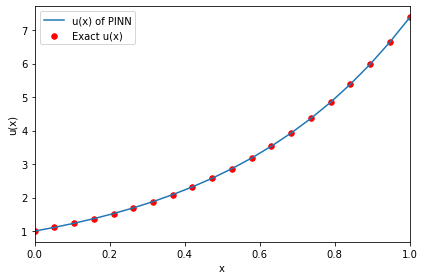

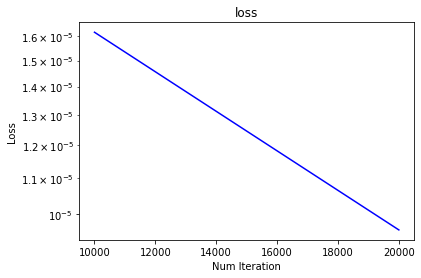

In [2]:


def ElasImag(nIter = 20000, print_period=1000, plot_period = 1000):
    x_range = np.array([a, b])
    # Network Structure
    layers_UV =[1, 30, 30,30, 5]
#     layers_UV =[1, 30, 30,30,30,30, 5]
    
#     layers_UV =[1, 60, 60,60, 5]

    Xx = np.linspace(x_range[0], x_range[1], 100)
    Xx = np.reshape(Xx, [-1, 1])

    f = open("loss1_record.txt", "w")

    num_train_tps =100
    num_test_tps =20

    model = PhysicsInformedNN(layers_UV,  x_range, f, num_train_tps)

    it_array = []
    loss_array = []
    losses_array = []
    start_time = time.time()
    for it in range(1, nIter+1):
        loss, losses = model.train(Xx, it, it%print_period==0)
        if (it%print_period==0):
            loss_array.append(loss)
            losses_array.append(losses)
            it_array.append(it)
            dt = time.time() - start_time
            print('Time: ', dt)
            start_time = time.time()
            if (it % plot_period == 0 or it == print_period):
                print("Result Plotted...")
                plt.figure(1)
                x_test, U_test, V1_test,V2_test,V3_test,V4_test, _,_, _, _, _, _, _,_,_,_= model.test(num_test_tps)
                u_exact = np.exp(2*x_test)
                # U = np.hstack((x_test,u_exact, U_test))
                print(u_exact,U_test)
                l2Uerror = np.linalg.norm(U_test - u_exact, 2) / np.linalg.norm(u_exact, 2)
                print('L2U error: ', l2Uerror)
                plt.figure()
                plt.plot(x_test, U_test, label='u(x) of PINN')
                plt.scatter(x_test, u_exact, s=30, c='r', marker='o', label='Exact u(x)')
                plt.legend(loc='upper left')
                plt.xlabel('x')
                plt.ylabel('u(x)')
                plt.xlim(x_range[0], x_range[1])
                plt.tight_layout()
                plt.show()
                figtopic = 'loss'
                plt.semilogy(it_array, loss_array, '-b')
                plt.xlabel("Num Iteration")
                plt.ylabel("Loss")
                plt.title(figtopic)
                plt.show()

ElasImag(nIter =20000, print_period =10000, plot_period =10000)